In [315]:
import hydra
import matplotlib.pyplot as plt
import numpy as np
import torch
from hydra import initialize, compose
from src.model.base import BaseTransformer
from src.dataset.sampler_sbi_prior import Sampler, sample_for_gaussian, sample_ar
from src.dataset.sbi.gaussian import Gaussian
from src.dataset.prior_sampler import PriorSampler
import os
import seaborn as sns
from sbi_demo_utils import *
from scipy.stats import norm, multivariate_normal
from torch.distributions import Uniform
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
path = "results/gaussian/"
cfg_pi_twoway, model_pi_twoway = load_config_and_model(path=path, ckpt_name="ckpt_2.tar")

In [262]:
batch_size = 5
dataset = Gaussian()

num_ctx_for_ppd = 10

# define sampler
sampler = Sampler(problem=dataset, 
                  batch_size=batch_size,
                  num_latent=2, 
                  min_num_points=num_ctx_for_ppd, 
                  max_num_points=num_ctx_for_ppd+1)

In [259]:
num_ctx_for_ppd = 4
batch_size = 10

eval_set = sample_for_gaussian(problem=dataset, 
                              batch_size=batch_size,
                              num_ctx='random',
                              num_latent=2, 
                              min_ctx_points=num_ctx_for_ppd, 
                              max_ctx_points=num_ctx_for_ppd+1,
                              num_bins=100,
                              mode="shift_mu")

out_all = model_pi_twoway.forward(eval_set, predict=True)
samples_all = out_all.samples

We expect the posterior to be affected by the prior, so in the first plot the posterior is shifted to the left, and in the second plot the posterior is shifted to the right.

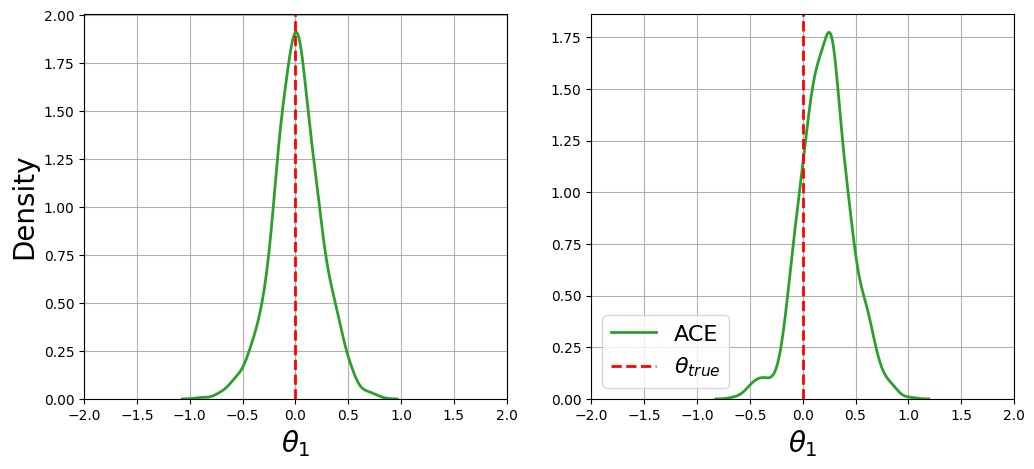

In [260]:
plt.figure(figsize=[12,5])

plt.subplot(1, 2, 1)
sns.kdeplot(samples_all[0, 0, :], color = "C2", linewidth = 2, linestyle = "solid", label = "ACE")
plt.axvline(x=eval_set.yt[0, 0].detach().numpy(), color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
plt.xlim(-2, 2)
plt.xlabel("$\\theta_1$", fontsize = 20)
plt.ylabel("Density", fontsize=20)
plt.grid()

plt.subplot(1, 2, 2)
sns.kdeplot(samples_all[9, 0, :], color = "C2", linewidth = 2, linestyle = "solid", label = "ACE")
plt.axvline(x=eval_set.yt[9, 0].detach().numpy(), color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
plt.xlim(-2, 2)
plt.legend(fontsize=16, loc=3)
plt.xlabel("$\\theta_1$", fontsize = 20)
plt.ylabel(None)
plt.grid()
plt.show()

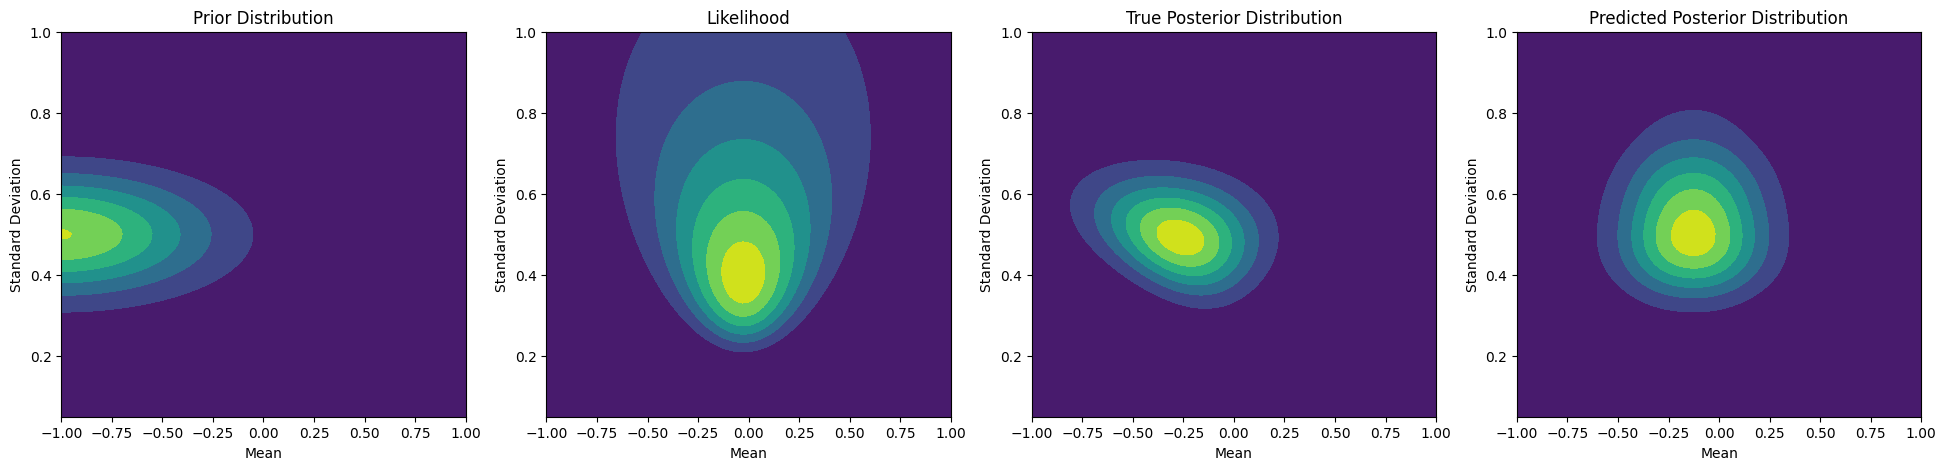

In [170]:
seed = 0

mean_range = np.linspace(-1, 1, num_bins)
std_range = np.linspace(0.05, 1, num_bins)
mean_grid, std_grid = np.meshgrid(mean_range, std_range)

mean_weight = out_all.mixture_weights[seed][0].detach().numpy()
mean_std = out_all.mixture_stds[seed][0].detach().numpy()
mean_mean = out_all.mixture_means[seed][0].detach().numpy()

std_weight = out_all.mixture_weights[seed][1].detach().numpy()
std_std = out_all.mixture_stds[seed][1].detach().numpy()
std_mean = out_all.mixture_means[seed][1].detach().numpy()

data = eval_set.yc_data[seed].reshape(-1).numpy()

bin_probs = eval_set.bins_latent_unknown[seed]  # 2, 100
mean_weights = bin_probs[0].numpy()
std_weights = bin_probs[1].numpy()

# Calculate log likelihood
log_likelihood_grid = np.zeros_like(mean_grid)
for i in range(mean_grid.shape[0]):
    for j in range(mean_grid.shape[1]):
        mean = mean_grid[i, j]
        std = std_grid[i, j]
        log_likelihood_grid[i, j] = np.sum(norm.logpdf(data, loc=mean, scale=std))

log_prior_grid = np.log(mean_weights[None, :] * std_weights[:, None])
log_posterior_grid = log_likelihood_grid + log_prior_grid

posterior_grid = np.exp(log_posterior_grid - np.max(log_posterior_grid)) 
posterior_grid /= np.sum(posterior_grid) 


log_predicted_posterior_grid = -np.inf * np.ones_like(mean_grid)

for k in range(len(mean_mean)):
    for l in range(len(std_mean)):
        log_mean_pdf = norm.logpdf(mean_grid, loc=mean_mean[k], scale=mean_std[k])
        log_std_pdf = norm.logpdf(std_grid, loc=std_mean[l], scale=std_std[l])

        log_component = np.log(mean_weight[k]) + np.log(std_weight[l]) + log_mean_pdf + log_std_pdf

        log_predicted_posterior_grid = np.logaddexp(log_predicted_posterior_grid, log_component)


predicted_posterior_grid = np.exp(log_predicted_posterior_grid - np.max(log_predicted_posterior_grid))
predicted_posterior_grid /= np.sum(predicted_posterior_grid)


fig, ax = plt.subplots(1, 4, figsize=[24, 5])
ax[0].contourf(mean_grid, std_grid, mean_weights[None, :] * std_weights[:, None], cmap='viridis')
ax[0].set_title('Prior Distribution')
ax[0].set_xlabel('Mean')
ax[0].set_ylabel('Standard Deviation')

ax[1].contourf(mean_grid, std_grid, np.exp(log_likelihood_grid - np.max(log_likelihood_grid)), cmap='viridis')
ax[1].set_title('Likelihood')
ax[1].set_xlabel('Mean')
ax[1].set_ylabel('Standard Deviation')

ax[2].contourf(mean_grid, std_grid, posterior_grid, cmap='viridis')
ax[2].set_title('True Posterior Distribution')
ax[2].set_xlabel('Mean')
ax[2].set_ylabel('Standard Deviation')

ax[3].contourf(mean_grid, std_grid, predicted_posterior_grid, cmap='viridis')
ax[3].set_title('Predicted Posterior Distribution')
ax[3].set_xlabel('Mean')
ax[3].set_ylabel('Standard Deviation')

plt.show()


# Visualization (Marginal)

In [265]:
num_ctx_for_ppd = 5
batch_size = 50

eval_set = sample_for_gaussian(problem=dataset, 
                              batch_size=batch_size,
                              num_ctx='random',
                              num_latent=2, 
                              min_ctx_points=num_ctx_for_ppd, 
                              max_ctx_points=num_ctx_for_ppd+1,
                              num_bins=100,
                              mode="fixed_data")

out_all = model_pi_twoway.forward(eval_set, predict=True)
samples_all = out_all.samples

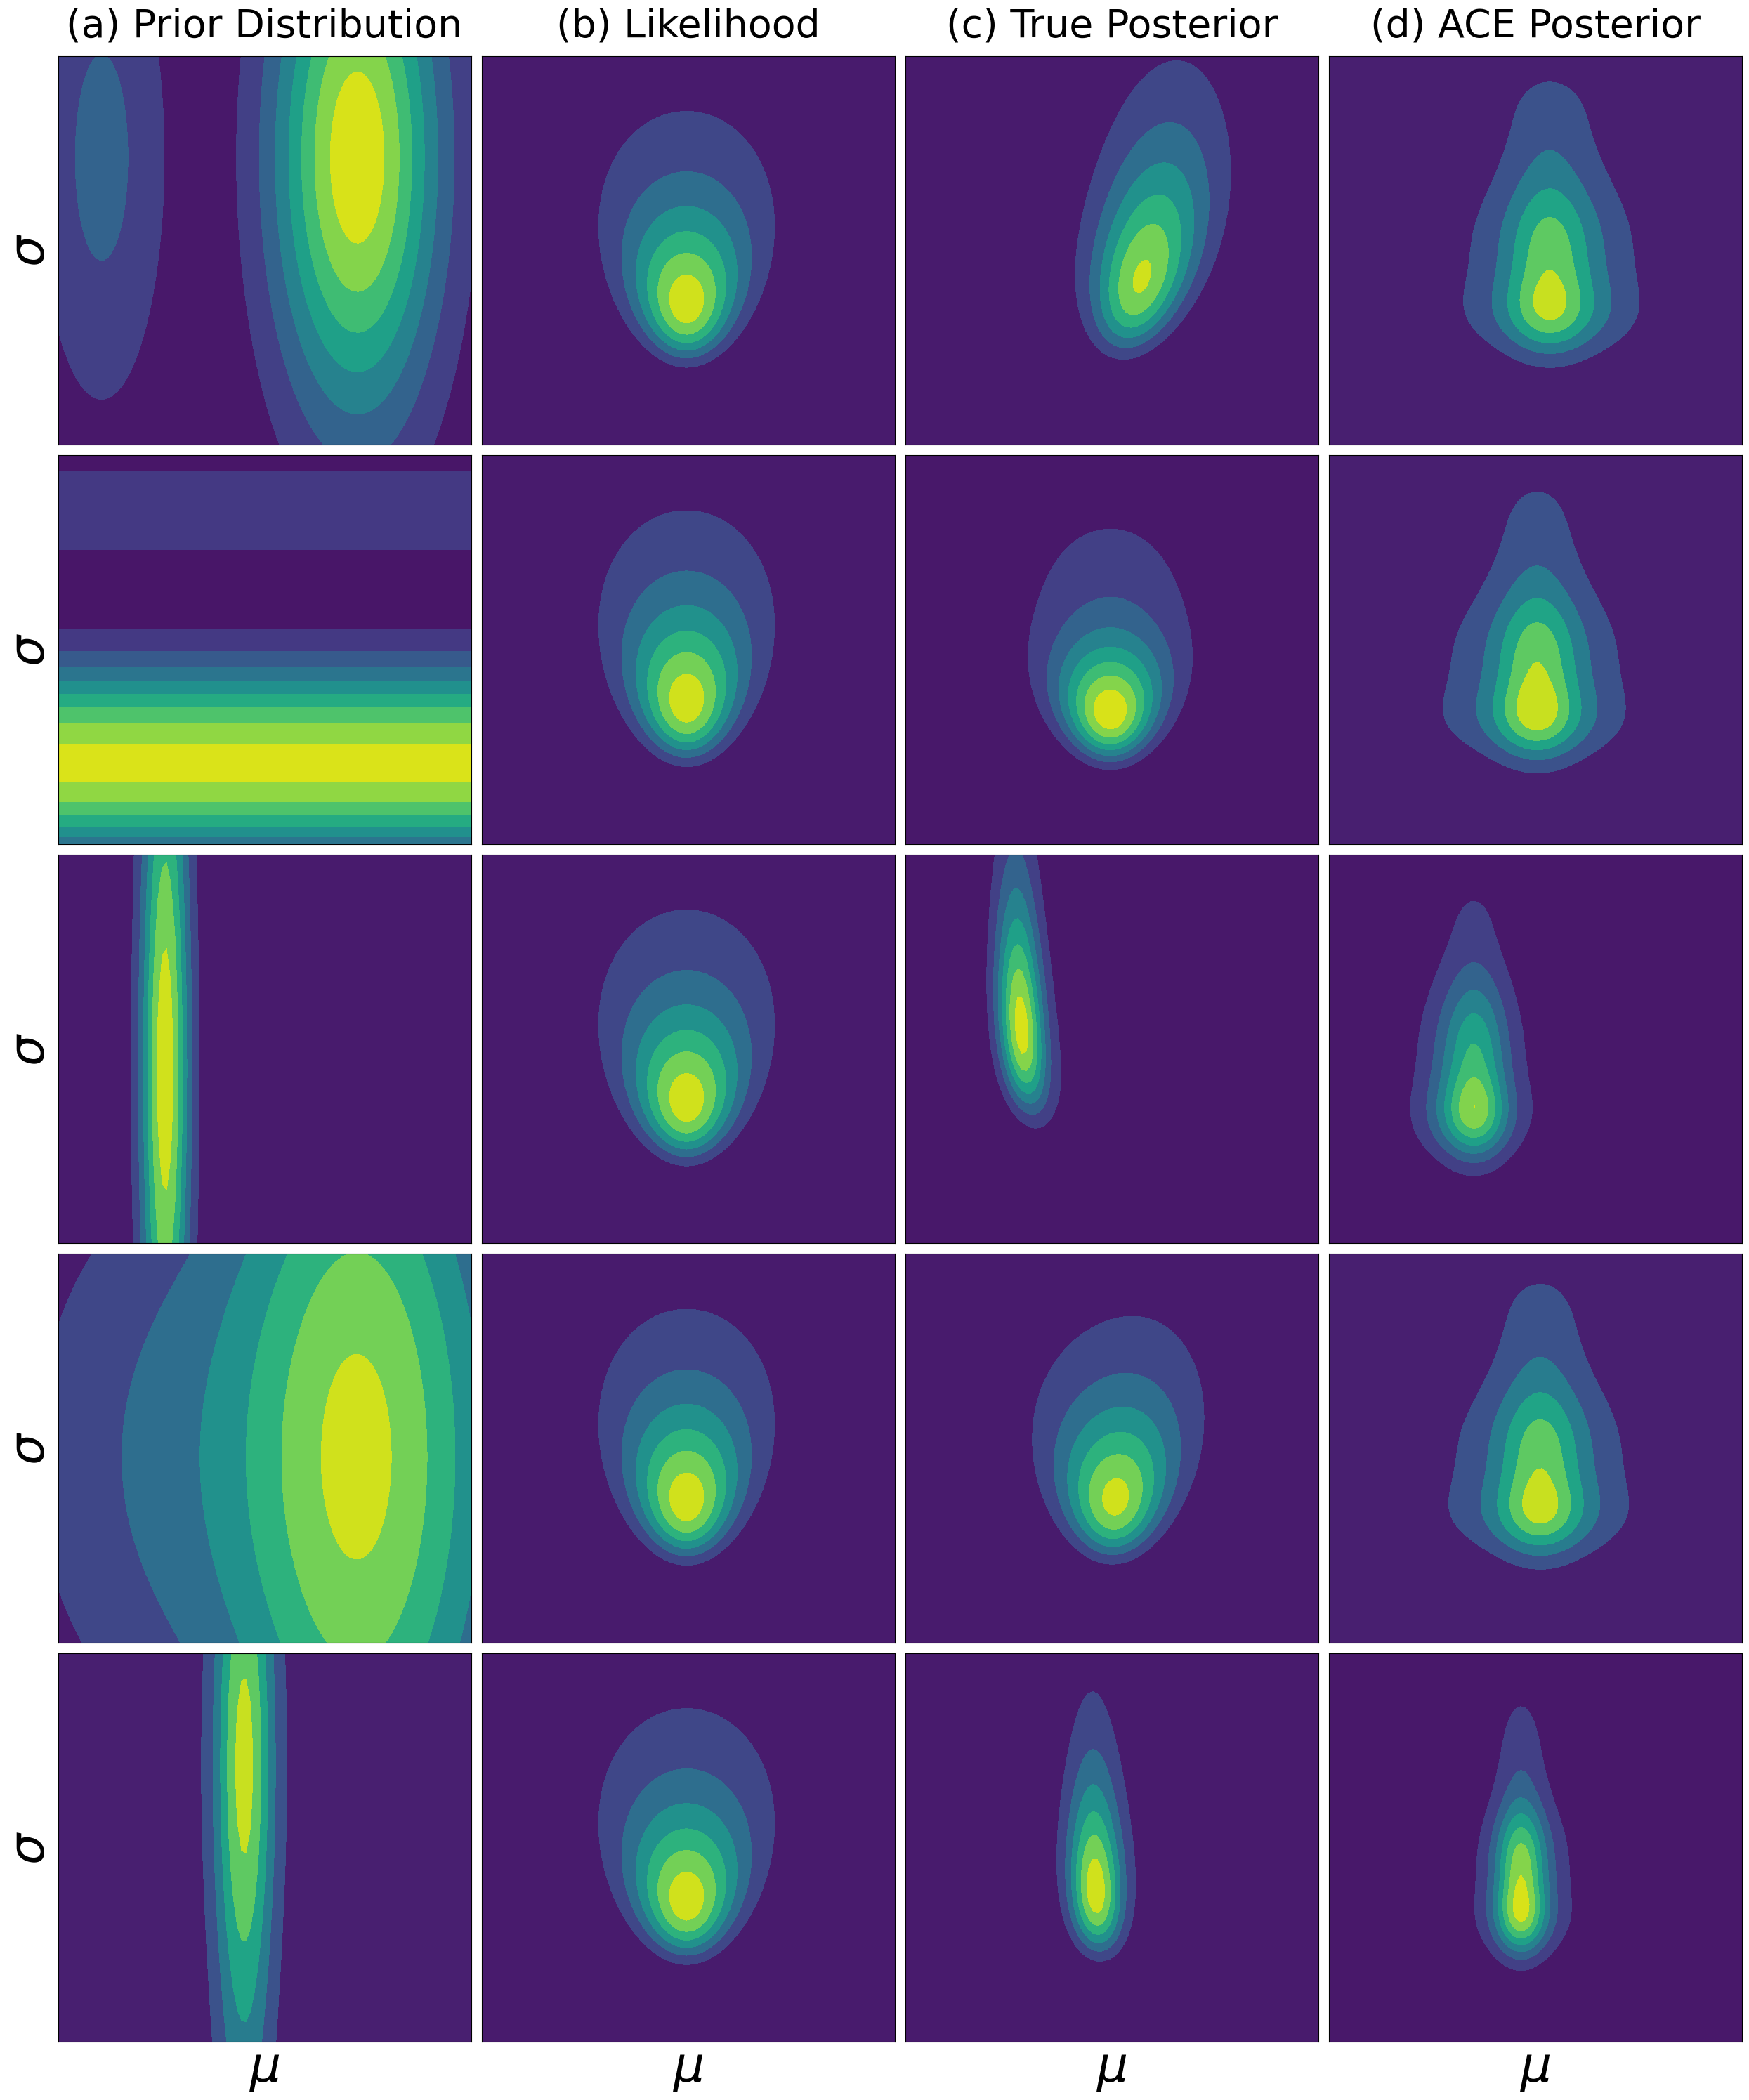

In [267]:
# Assuming out_all and eval_set are predefined
seeds = [6, 7, 8, 9, 10]

# Initialize the canvas, only for the posterior distribution plots of the first five seeds
fig, axs = plt.subplots(5, 4, figsize=(25, 30))

# Titles for each column
column_titles = ['(a) Prior Distribution', '(b) Likelihood', '(c) True Posterior', '(d) ACE Posterior']

for idx, seed in enumerate(seeds):
    # p(mean | D)
    mean_weight = out_all.mixture_weights[seed][0].detach().numpy()
    mean_std = out_all.mixture_stds[seed][0].detach().numpy()
    mean_mean = out_all.mixture_means[seed][0].detach().numpy()

    # p(std | D)
    std_weight = out_all.mixture_weights[seed][1].detach().numpy()
    std_std = out_all.mixture_stds[seed][1].detach().numpy()
    std_mean = out_all.mixture_means[seed][1].detach().numpy()

    # data generated from true gaussian
    data = eval_set.yc_data[seed].reshape(-1).numpy()

    # bin weights of prior distribution
    bin_probs = eval_set.bins_latent_unknown[seed]  # 2, 100
    mean_bin_weights = bin_probs[0].numpy()
    std_bin_weights = bin_probs[1].numpy()

    # grid size
    num_bins = 100
    mean_range = np.linspace(-1, 1, num_bins)
    std_range = np.linspace(0.05, 1, num_bins)
    mean_grid, std_grid = np.meshgrid(mean_range, std_range)

    # log likelihood
    log_likelihood_grid = np.zeros_like(mean_grid)
    for i in range(mean_grid.shape[0]):
        for j in range(mean_grid.shape[1]):
            mean = mean_grid[i, j]
            std = std_grid[i, j]
            log_likelihood_grid[i, j] = np.sum(norm.logpdf(data, loc=mean, scale=std))

    # log prior
    log_prior_grid = np.log(std_bin_weights[:, None]) + np.log(mean_bin_weights[None, :])

    # log true posterior
    log_posterior_grid = log_likelihood_grid + log_prior_grid
    log_posterior_grid -= np.max(log_posterior_grid)
    posterior_grid = np.exp(log_posterior_grid)
    posterior_grid /= np.sum(posterior_grid)

    # log predicted posterior grid initialization
    log_predicted_posterior_grid = -np.inf * np.ones_like(mean_grid)

    # Compute p(mean | D) and p(std | D) and convert to grid weights
    for k in range(len(mean_mean)):
        log_mean_pdf = norm.logpdf(mean_grid, loc=mean_mean[k], scale=mean_std[k])
        for l in range(len(std_mean)):
            log_std_pdf = norm.logpdf(std_grid, loc=std_mean[l], scale=std_std[l])
            log_component = np.log(mean_weight[k]) + np.log(std_weight[l]) + log_mean_pdf + log_std_pdf
            log_predicted_posterior_grid = np.logaddexp(log_predicted_posterior_grid, log_component)

    # Normalize predicted posterior in log space
    log_predicted_posterior_grid -= np.max(log_predicted_posterior_grid)
    predicted_posterior_grid = np.exp(log_predicted_posterior_grid)
    predicted_posterior_grid /= np.sum(predicted_posterior_grid)

    # Visualize the posterior distribution for the first five seeds
    if idx < 5:
        axs[idx, 0].contourf(mean_grid, std_grid, std_bin_weights[:, None] * mean_bin_weights[None, :], cmap='viridis')
        if idx > 3:
            axs[idx, 0].set_xlabel('$\mu$', fontsize=50)
        axs[idx, 0].set_ylabel('$\sigma$', fontsize=50)
        axs[idx, 0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

        axs[idx, 1].contourf(mean_grid, std_grid, np.exp(log_likelihood_grid - np.max(log_likelihood_grid)), cmap='viridis')
        if idx > 3:
            axs[idx, 1].set_xlabel('$\mu$', fontsize=50)
        # axs[idx, 1].set_ylabel('Standard Deviation', fontsize=30)
        axs[idx, 1].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

        axs[idx, 2].contourf(mean_grid, std_grid, posterior_grid, cmap='viridis')
        if idx > 3:
            axs[idx, 2].set_xlabel('$\mu$', fontsize=50)
        # axs[idx, 2].set_ylabel('Standard Deviation', fontsize=30)
        axs[idx, 2].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

        axs[idx, 3].contourf(mean_grid, std_grid, predicted_posterior_grid, cmap='viridis')
        if idx > 3:
            axs[idx, 3].set_xlabel('$\mu$', fontsize=50)
        # axs[idx, 3].set_ylabel('Standard Deviation', fontsize=30)
        axs[idx, 3].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Add column titles
for ax, col in zip(axs[0], column_titles):
    ax.set_title(col, fontsize=40, pad=20)

plt.tight_layout()
# plt.savefig("figures/gaussian_examples.pdf")
plt.show()


In [ ]:
# Assuming out_all and eval_set are predefined
seeds = np.arange(0, 100)

# Determine the number of rows and columns based on the number of seeds
num_rows = len(seeds)
num_cols = 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(25, num_rows * 6))

# Initialize arrays to save means and standard deviations
results = {
    'true_mean_mean': [],
    'predicted_mean_mean': [],
    'true_mean_std': [],
    'predicted_mean_std': [],
    'true_std_mean': [],
    'predicted_std_mean': [],
    'true_std_std': [],
    'predicted_std_std': []
}

# Titles for each column
column_titles = ['Prior Distribution', 'Likelihood', 'True Posterior Distribution', 'Predicted Posterior Distribution']

for idx, seed in enumerate(seeds):
    # p(mean | D)
    mean_weight = out_all.mixture_weights[seed][0].detach().numpy()
    mean_std = out_all.mixture_stds[seed][0].detach().numpy()
    mean_mean = out_all.mixture_means[seed][0].detach().numpy()

    # p(std | D)
    std_weight = out_all.mixture_weights[seed][1].detach().numpy()
    std_std = out_all.mixture_stds[seed][1].detach().numpy()
    std_mean = out_all.mixture_means[seed][1].detach().numpy()

    # data generated from true gaussian
    data = eval_set.yc_data[seed].reshape(-1).numpy()

    # bin weights of prior distribution
    bin_probs = eval_set.bins_latent_unknown[seed]  # 2, 100
    mean_bin_weights = bin_probs[0].numpy()
    std_bin_weights = bin_probs[1].numpy()

    # grid size
    num_bins = 100
    mean_range = np.linspace(-1, 1, num_bins)
    std_range = np.linspace(0.05, 1, num_bins)
    mean_grid, std_grid = np.meshgrid(mean_range, std_range)

    # log likelihood
    log_likelihood_grid = np.zeros_like(mean_grid)
    for i in range(mean_grid.shape[0]):
        for j in range(mean_grid.shape[1]):
            mean = mean_grid[i, j]
            std = std_grid[i, j]
            log_likelihood_grid[i, j] = np.sum(norm.logpdf(data, loc=mean, scale=std))

    # log prior
    log_prior_grid = np.log(std_bin_weights[:, None]) + np.log(mean_bin_weights[None, :])

    # log true posterior
    log_posterior_grid = log_likelihood_grid + log_prior_grid
    log_posterior_grid -= np.max(log_posterior_grid)
    posterior_grid = np.exp(log_posterior_grid)
    posterior_grid /= np.sum(posterior_grid)

    # log predicted posterior grid initialization
    log_predicted_posterior_grid = -np.inf * np.ones_like(mean_grid)

    # Compute p(mean | D) and p(std | D) and convert to grid weights
    for k in range(len(mean_mean)):
        log_mean_pdf = norm.logpdf(mean_grid, loc=mean_mean[k], scale=mean_std[k])
        for l in range(len(std_mean)):
            log_std_pdf = norm.logpdf(std_grid, loc=std_mean[l], scale=std_std[l])
            log_component = np.log(mean_weight[k]) + np.log(std_weight[l]) + log_mean_pdf + log_std_pdf
            log_predicted_posterior_grid = np.logaddexp(log_predicted_posterior_grid, log_component)

    # Normalize predicted posterior in log space
    log_predicted_posterior_grid -= np.max(log_predicted_posterior_grid)
    predicted_posterior_grid = np.exp(log_predicted_posterior_grid)
    predicted_posterior_grid /= np.sum(predicted_posterior_grid)

    # Calculate marginal distribution p(mean | D)
    marginalized_posterior_mean_true = np.sum(posterior_grid, axis=0)
    marginalized_posterior_mean_predicted = np.sum(predicted_posterior_grid, axis=0)

    # Calculate marginal distribution p(std | D)
    marginalized_posterior_std_true = np.sum(posterior_grid, axis=1)
    marginalized_posterior_std_predicted = np.sum(predicted_posterior_grid, axis=1)

    # Calculate mean and std of marginal distributions
    posterior_mean_true_mean = np.sum(marginalized_posterior_mean_true * mean_range) / np.sum(marginalized_posterior_mean_true)
    posterior_mean_true_std = np.sqrt(np.sum(marginalized_posterior_mean_true * (mean_range - posterior_mean_true_mean)**2) / np.sum(marginalized_posterior_mean_true))

    posterior_std_true_mean = np.sum(marginalized_posterior_std_true * std_range) / np.sum(marginalized_posterior_std_true)
    posterior_std_true_std = np.sqrt(np.sum(marginalized_posterior_std_true * (std_range - posterior_std_true_mean)**2) / np.sum(marginalized_posterior_std_true))

    posterior_mean_predicted_mean = np.sum(marginalized_posterior_mean_predicted * mean_range) / np.sum(marginalized_posterior_mean_predicted)
    posterior_mean_predicted_std = np.sqrt(np.sum(marginalized_posterior_mean_predicted * (mean_range - posterior_mean_predicted_mean)**2) / np.sum(marginalized_posterior_mean_predicted))

    posterior_std_predicted_mean = np.sum(marginalized_posterior_std_predicted * std_range) / np.sum(marginalized_posterior_std_predicted)
    posterior_std_predicted_std = np.sqrt(np.sum(marginalized_posterior_std_predicted * (std_range - posterior_std_predicted_mean)**2) / np.sum(marginalized_posterior_std_predicted))

    # Save results
    results['true_mean_mean'].append(posterior_mean_true_mean)
    results['predicted_mean_mean'].append(posterior_mean_predicted_mean)
    results['true_mean_std'].append(posterior_mean_true_std)
    results['predicted_mean_std'].append(posterior_mean_predicted_std)
    results['true_std_mean'].append(posterior_std_true_mean)
    results['predicted_std_mean'].append(posterior_std_predicted_mean)
    results['true_std_std'].append(posterior_std_true_std)
    results['predicted_std_std'].append(posterior_std_predicted_std)

    # Visualize the posterior distribution for all seeds
    axs[idx, 0].contourf(mean_grid, std_grid, std_bin_weights[:, None] * mean_bin_weights[None, :], cmap='viridis')
    axs[idx, 0].set_xlabel('Mean', fontsize=14)
    axs[idx, 0].set_ylabel('Standard Deviation', fontsize=14)
    axs[idx, 0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    axs[idx, 1].contourf(mean_grid, std_grid, np.exp(log_likelihood_grid - np.max(log_likelihood_grid)), cmap='viridis')
    axs[idx, 1].set_xlabel('Mean', fontsize=14)
    axs[idx, 1].set_ylabel('Standard Deviation', fontsize=14)
    axs[idx, 1].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    axs[idx, 2].contourf(mean_grid, std_grid, posterior_grid, cmap='viridis')
    axs[idx, 2].set_xlabel('Mean', fontsize=14)
    axs[idx, 2].set_ylabel('Standard Deviation', fontsize=14)
    axs[idx, 2].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    axs[idx, 3].contourf(mean_grid, std_grid, predicted_posterior_grid, cmap='viridis')
    axs[idx, 3].set_xlabel('Mean', fontsize=14)
    axs[idx, 3].set_ylabel('Standard Deviation', fontsize=14)
    axs[idx, 3].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Add column titles
for ax, col in zip(axs[0], column_titles):
    ax.set_title(col, fontsize=20, pad=10)

plt.tight_layout()
plt.show()


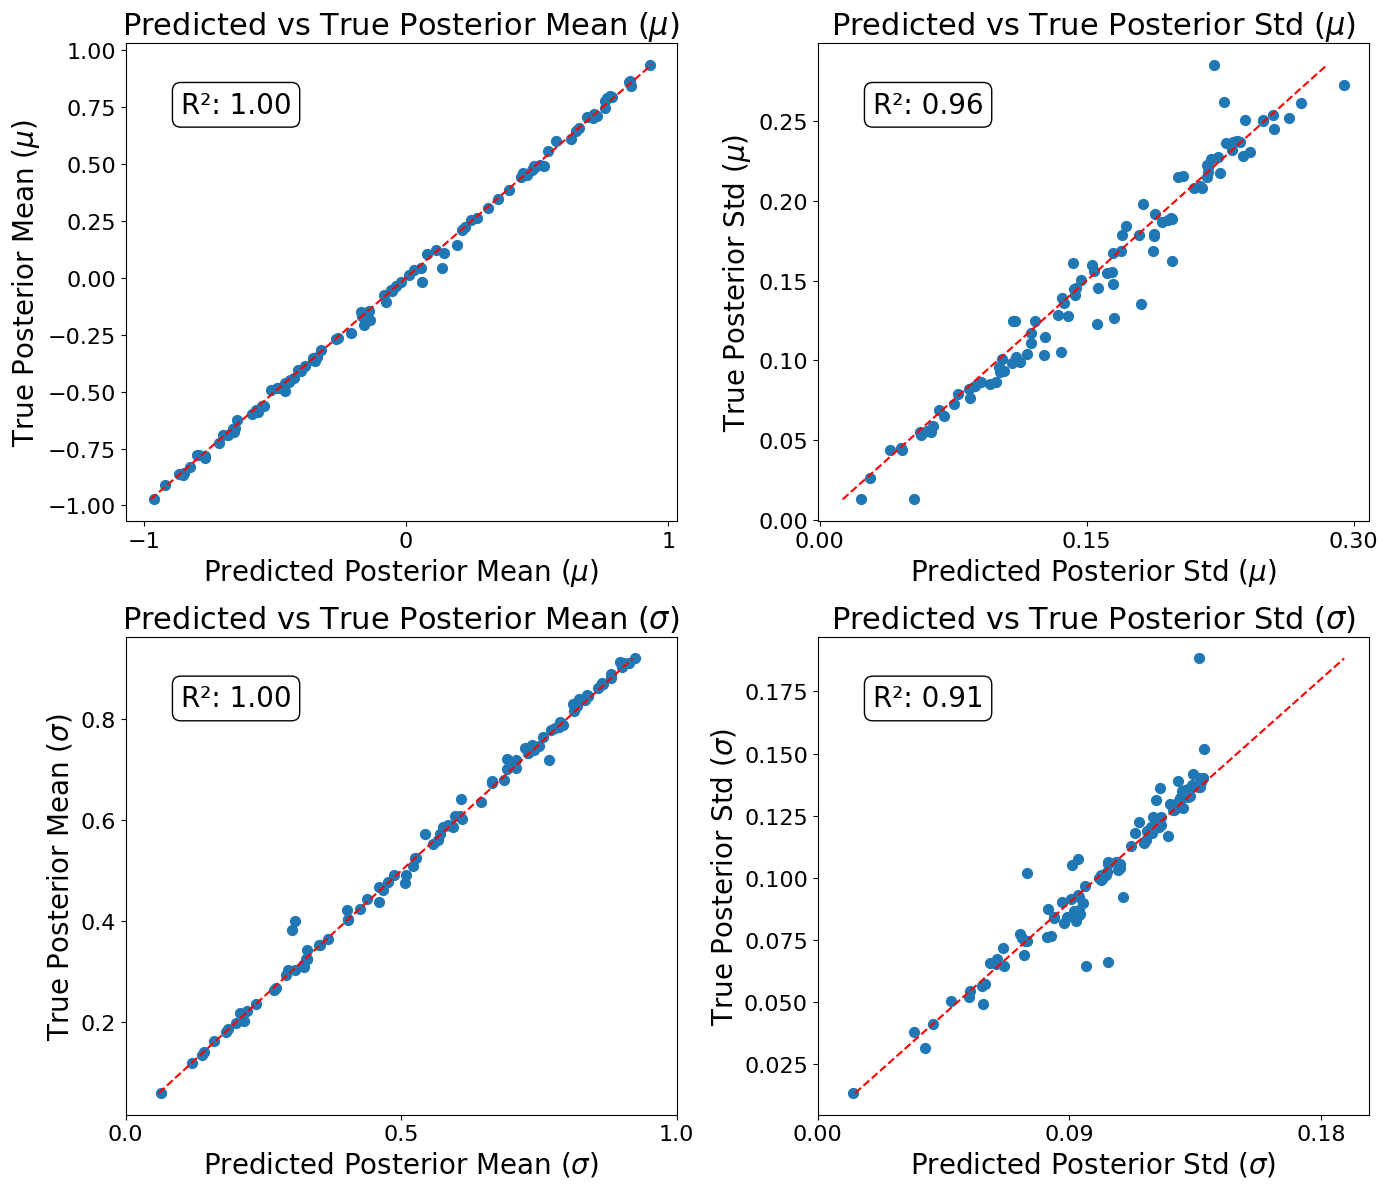

In [188]:
from sklearn.metrics import r2_score

plt.figure(figsize=(14, 12))

# theta 1 mean
plt.subplot(2, 2, 1)
plt.scatter(results['predicted_mean_mean'], results['true_mean_mean'], s=50)
plt.plot([min(results['true_mean_mean']), max(results['true_mean_mean'])], 
         [min(results['true_mean_mean']), max(results['true_mean_mean'])], 'r--')
r2_mean_mean = r2_score(results['true_mean_mean'], results['predicted_mean_mean'])
plt.xlabel(r'Predicted Posterior Mean ($\mu$)', fontsize=20)
plt.ylabel(r'True Posterior Mean ($\mu$)', fontsize=20)
plt.title(r'Predicted vs True Posterior Mean ($\mu$)', fontsize=22)
plt.xticks([-1.0, 0, 1.0], fontsize=16)
plt.yticks(fontsize=16)
plt.text(0.10, 0.9, f'R²: {r2_mean_mean:.2f}', fontsize=20, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# theta 1 std
plt.subplot(2, 2, 2)
plt.scatter(results['predicted_mean_std'], results['true_mean_std'], s=50)
plt.plot([min(results['true_mean_std']), max(results['true_mean_std'])], 
         [min(results['true_mean_std']), max(results['true_mean_std'])], 'r--')
r2_mean_std = r2_score(results['true_mean_std'], results['predicted_mean_std'])
plt.xlabel(r'Predicted Posterior Std ($\mu$)', fontsize=20)
plt.ylabel(r'True Posterior Std ($\mu$)', fontsize=20)
plt.title(r'Predicted vs True Posterior Std ($\mu$)', fontsize=22)
plt.xticks([0, 0.15, 0.30], fontsize=16)
plt.yticks(fontsize=16)
plt.text(0.10, 0.9, f'R²: {r2_mean_std:.2f}', fontsize=20, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# theta 2 mean
plt.subplot(2, 2, 3)
plt.scatter(results['predicted_std_mean'], results['true_std_mean'], s=50)
plt.plot([min(results['true_std_mean']), max(results['true_std_mean'])], 
         [min(results['true_std_mean']), max(results['true_std_mean'])], 'r--')
r2_std_mean = r2_score(results['true_std_mean'], results['predicted_std_mean'])
plt.xlabel(r'Predicted Posterior Mean ($\sigma$)', fontsize=20)
plt.ylabel(r'True Posterior Mean ($\sigma$)', fontsize=20)
plt.title(r'Predicted vs True Posterior Mean ($\sigma$)', fontsize=22)
plt.xticks([0, 0.5, 1.0],fontsize=16)
plt.yticks(fontsize=16)
plt.text(0.10, 0.9, f'R²: {r2_std_mean:.2f}', fontsize=20, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# theta 2 std
plt.subplot(2, 2, 4)
plt.scatter(results['predicted_std_std'], results['true_std_std'], s=50)
plt.plot([min(results['true_std_std']), max(results['true_std_std'])], 
         [min(results['true_std_std']), max(results['true_std_std'])], 'r--')
r2_std_std = r2_score(results['true_std_std'], results['predicted_std_std'])
plt.xlabel(r'Predicted Posterior Std ($\sigma$)', fontsize=20)
plt.ylabel(r'True Posterior Std ($\sigma$)', fontsize=20)
plt.title(r'Predicted vs True Posterior Std ($\sigma$)', fontsize=22)
plt.xticks([0, 0.09, 0.18],fontsize=16)
plt.yticks(fontsize=16)
plt.text(0.10, 0.9, f'R²: {r2_std_std:.2f}', fontsize=20, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

plt.tight_layout()
# plt.savefig("figures/gaussian_scatter.pdf")
plt.show()


# Final plot generation (marginal case)

In [268]:
from scipy.stats import norm
from mpl_toolkits.axes_grid1 import make_axes_locatable

seeds = [7]  # Replace with any seeds you want to visualize

# Initialize arrays to save means and standard deviations
results = {
    'true_mean_mean': [],
    'predicted_mean_mean': [],
    'true_mean_std': [],
    'predicted_mean_std': [],
    'true_std_mean': [],
    'predicted_std_mean': [],
    'true_std_std': [],
    'predicted_std_std': []
}

# Titles for each figure
figure_titles = ['Prior Distribution', 'Likelihood', 'True Posterior', 'ACE Posterior']
column_titles = ['(a) Prior Distribution', '(b) Likelihood', '(c) True Posterior', '(d) ACE Posterior']

# Create figures for each type of plot
figures = []
axs_list = []

num_rows = len(seeds)

for idx, seed in enumerate(seeds):
    # p(mean | D)
    mean_weight = out_all.mixture_weights[seed][0].detach().numpy()
    mean_std = out_all.mixture_stds[seed][0].detach().numpy()
    mean_mean = out_all.mixture_means[seed][0].detach().numpy()

    # p(std | D)
    std_weight = out_all.mixture_weights[seed][1].detach().numpy()
    std_std = out_all.mixture_stds[seed][1].detach().numpy()
    std_mean = out_all.mixture_means[seed][1].detach().numpy()

    # data generated from true gaussian
    data = eval_set.yc_data[seed].reshape(-1).numpy()

    # bin weights of prior distribution
    bin_probs = eval_set.bins_latent_unknown[seed]  # 2, 100
    mean_bin_weights = bin_probs[0].numpy()
    std_bin_weights = bin_probs[1].numpy()

    # grid size
    num_bins = 100
    mean_range = np.linspace(-1, 1, num_bins)
    std_range = np.linspace(0.05, 1, num_bins)
    mean_grid, std_grid = np.meshgrid(mean_range, std_range)

    # log likelihood
    log_likelihood_grid = np.zeros_like(mean_grid)
    for i in range(mean_grid.shape[0]):
        for j in range(mean_grid.shape[1]):
            mean = mean_grid[i, j]
            std = std_grid[i, j]
            log_likelihood_grid[i, j] = np.sum(norm.logpdf(data, loc=mean, scale=std))

    # log prior
    log_prior_grid = np.log(std_bin_weights[:, None]) + np.log(mean_bin_weights[None, :])

    # log true posterior
    log_posterior_grid = log_likelihood_grid + log_prior_grid
    log_posterior_grid -= np.max(log_posterior_grid)
    posterior_grid = np.exp(log_posterior_grid)
    posterior_grid /= np.sum(posterior_grid)

    # log predicted posterior grid initialization
    log_predicted_posterior_grid = -np.inf * np.ones_like(mean_grid)

    # Compute p(mean | D) and p(std | D) and convert to grid weights
    for k in range(len(mean_mean)):
        log_mean_pdf = norm.logpdf(mean_grid, loc=mean_mean[k], scale=mean_std[k])
        for l in range(len(std_mean)):
            log_std_pdf = norm.logpdf(std_grid, loc=std_mean[l], scale=std_std[l])
            log_component = np.log(mean_weight[k]) + np.log(std_weight[l]) + log_mean_pdf + log_std_pdf
            log_predicted_posterior_grid = np.logaddexp(log_predicted_posterior_grid, log_component)

    # Normalize predicted posterior in log space
    log_predicted_posterior_grid -= np.max(log_predicted_posterior_grid)
    predicted_posterior_grid = np.exp(log_predicted_posterior_grid)
    predicted_posterior_grid /= np.sum(predicted_posterior_grid)

    # Calculate marginal distribution p(mean | D)
    marginalized_posterior_mean_true = np.sum(posterior_grid, axis=0)
    marginalized_posterior_mean_predicted = np.sum(predicted_posterior_grid, axis=0)

    # Calculate marginal distribution p(std | D)
    marginalized_posterior_std_true = np.sum(posterior_grid, axis=1)
    marginalized_posterior_std_predicted = np.sum(predicted_posterior_grid, axis=1)

    # Calculate mean and std of marginal distributions
    posterior_mean_true_mean = np.sum(marginalized_posterior_mean_true * mean_range) / np.sum(marginalized_posterior_mean_true)
    posterior_mean_true_std = np.sqrt(np.sum(marginalized_posterior_mean_true * (mean_range - posterior_mean_true_mean)**2) / np.sum(marginalized_posterior_mean_true))

    posterior_std_true_mean = np.sum(marginalized_posterior_std_true * std_range) / np.sum(marginalized_posterior_std_true)
    posterior_std_true_std = np.sqrt(np.sum(marginalized_posterior_std_true * (std_range - posterior_std_true_mean)**2) / np.sum(marginalized_posterior_std_true))

    posterior_mean_predicted_mean = np.sum(marginalized_posterior_mean_predicted * mean_range) / np.sum(marginalized_posterior_mean_predicted)
    posterior_mean_predicted_std = np.sqrt(np.sum(marginalized_posterior_mean_predicted * (mean_range - posterior_mean_predicted_mean)**2) / np.sum(marginalized_posterior_mean_predicted))

    posterior_std_predicted_mean = np.sum(marginalized_posterior_std_predicted * std_range) / np.sum(marginalized_posterior_std_predicted)
    posterior_std_predicted_std = np.sqrt(np.sum(marginalized_posterior_std_predicted * (std_range - posterior_std_predicted_mean)**2) / np.sum(marginalized_posterior_std_predicted))

    # Save results
    results['true_mean_mean'].append(posterior_mean_true_mean)
    results['predicted_mean_mean'].append(posterior_mean_predicted_mean)
    results['true_mean_std'].append(posterior_mean_true_std)
    results['predicted_mean_std'].append(posterior_mean_predicted_std)
    results['true_std_mean'].append(posterior_std_true_mean)
    results['predicted_std_mean'].append(posterior_std_predicted_mean)
    results['true_std_std'].append(posterior_std_true_std)
    results['predicted_std_std'].append(posterior_std_predicted_std)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    divider = make_axes_locatable(ax)
    ax_top = divider.append_axes("top", size="20%", pad=0.0, sharex=ax)
    ax_left = divider.append_axes("left", size="20%", pad=0.0, sharey=ax)


    for axis in [ax, ax_top, ax_left]:
        axis.patch.set_facecolor('none')
        axis.spines['top'].set_visible(False)
        axis.spines['right'].set_visible(False)
        axis.spines['bottom'].set_visible(False)
        axis.spines['left'].set_visible(False)

    # Prior
    prior_joint = std_bin_weights[:, None] * mean_bin_weights[None, :]
    im = ax.contourf(mean_grid, std_grid, prior_joint, cmap='viridis')
    ax.tick_params(axis='both', which='both', bottom=False, left=False,
                   labelbottom=False, labelleft=False)
    ax.set_xlim(-1, 1)
    ax.set_ylim(0.05, 1)


    ax_top.set_ylim(0, max(mean_bin_weights))
    ax_left.set_xlim(0, max(std_bin_weights))

    cmap = plt.get_cmap('viridis')


    mean_norm = mean_bin_weights / mean_bin_weights.max()
    mean_bin_width = mean_range[1] - mean_range[0]
    for i in range(len(mean_range)):
        color = cmap(mean_norm[i])
        ax_top.bar(mean_range[i], mean_bin_weights[i], width=mean_bin_width, align='center',
                   color='none', edgecolor=color)

    ax_top.axis('off')

    std_bin_width = std_range[1] - std_range[0]
    std_norm = std_bin_weights / std_bin_weights.max()
    for i in range(len(std_range)):
        color = cmap(std_norm[i])
        ax_left.barh(std_range[i], std_bin_weights[i], height=std_bin_width, align='center',
                     color='none', edgecolor=color)
    ax_left.invert_xaxis()
    ax_left.axis('off')


    ax_top.set_xlim(ax.get_xlim())
    ax_left.set_ylim(ax.get_ylim())

    plt.tight_layout()
    plt.savefig(f'prior_distribution_seed_{seed}.png', bbox_inches='tight', dpi=300)
    plt.close(fig)
    # plt.show()

    # Likelihood
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.contourf(mean_grid, std_grid, np.exp(log_likelihood_grid - np.max(log_likelihood_grid)), cmap='viridis')
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax.set_xlim(-1, 1)
    ax.set_ylim(0.05, 1)
    plt.tight_layout()
    plt.savefig(f'likelihood_seed_{seed}.png', bbox_inches='tight', dpi=300)
    plt.close(fig)


    # True Posterior
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.contourf(mean_grid, std_grid, posterior_grid, cmap='viridis')
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    ax.set_xlim(-1, 1)
    ax.set_ylim(0.05, 1)
    plt.tight_layout()
    plt.savefig(f'true_posterior_seed_{seed}.png', bbox_inches='tight', dpi=300)
    plt.close(fig)


    # ACE Posterior
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.contourf(mean_grid, std_grid, predicted_posterior_grid, cmap='viridis')
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    ax.set_xlim(-1, 1)
    ax.set_ylim(0.05, 1)
    plt.tight_layout()
    plt.savefig(f'ace_posterior_seed_{seed}.png', bbox_inches='tight', dpi=300)
    plt.close(fig)
    plt.show()

# AR

In [478]:
joint_mean_theta_1 = 0.0
joint_mean_theta_2 = 0.5
joint_std_theta_1 = 0.2
joint_std_theta_2 = 0.2
joint_rho = 0.5

num_ctx = 5

batch_theta_1_marginal, batch_theta_1_cond, batch_theta_2_marginal, batch_theta_2_cond = sample_ar(dataset,
                                                                                                   num_ctx,
                                                                                                   joint_mean_theta_1,
                                                                                                   joint_mean_theta_2,
                                                                                                   joint_std_theta_1,
                                                                                                   joint_std_theta_2,
                                                                                                   joint_rho)

out_theta_1_marginal = model_pi_twoway.forward(batch_theta_1_marginal, predict=True)
samples_theta_1_marginal = out_theta_1_marginal.samples

out_theta_2_marginal = model_pi_twoway.forward(batch_theta_2_marginal, predict=True)
samples_theta_2_marginal = out_theta_2_marginal.samples

out_theta_1_cond = model_pi_twoway.forward(batch_theta_1_cond, predict=True)
samples_theta_1_cond = out_theta_1_cond.samples

out_theta_2_cond = model_pi_twoway.forward(batch_theta_2_cond, predict=True)
samples_theta_2_cond = out_theta_2_cond.samples

# p(mean | D)
theta_1_posterior_weight = out_theta_1_marginal.mixture_weights[0, 0].detach().numpy()
theta_1_posterior_std = out_theta_1_marginal.mixture_stds[0, 0].detach().numpy()
theta_1_posterior_mean = out_theta_1_marginal.mixture_means[0, 0].detach().numpy()

# p(std | D)
theta_2_posterior_weight = out_theta_2_marginal.mixture_weights[0, 1].detach().numpy()
theta_2_posterior_std = out_theta_2_marginal.mixture_stds[0, 1].detach().numpy()
theta_2_posterior_mean = out_theta_2_marginal.mixture_means[0, 1].detach().numpy()

# p(mean | std, D)
theta_1_cond_weight = out_theta_2_cond.mixture_weights[:, 0, :].detach().numpy()  # shape: (100, 20)
theta_1_cond_std = out_theta_2_cond.mixture_stds[:, 0, :].detach().numpy()        # shape: (100, 20)
theta_1_cond_mean = out_theta_2_cond.mixture_means[:, 0, :].detach().numpy()      # shape: (100, 20)

# p(std | mean, D)
theta_2_cond_weight = out_theta_1_cond.mixture_weights[:, 0, :].detach().numpy()  # shape: (100, 20)
theta_2_cond_std = out_theta_1_cond.mixture_stds[:, 0, :].detach().numpy()        # shape: (100, 20)
theta_2_cond_mean = out_theta_1_cond.mixture_means[:, 0, :].detach().numpy()      # shape: (100, 20)

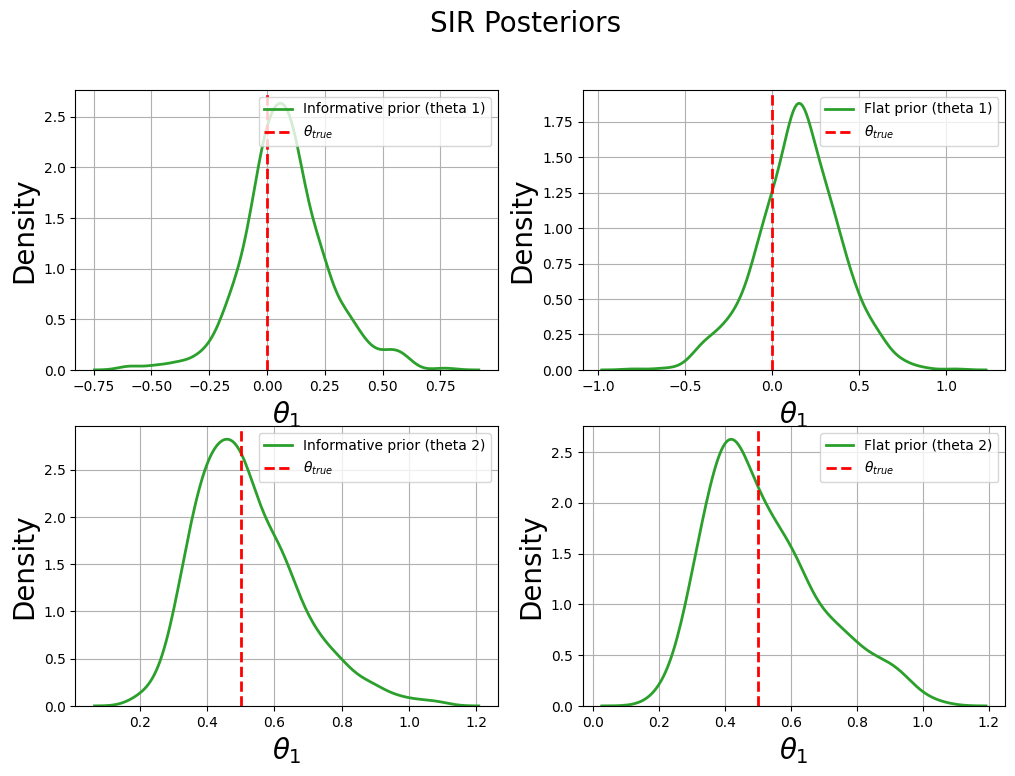

In [479]:
plt.figure(figsize=[12,8])
plt.suptitle(f"SIR Posteriors", size=20)
plt.subplot(2, 2, 1)
sns.kdeplot(samples_theta_1_marginal[0, 0, :], color = "C2", linewidth = 2, linestyle = "solid", label = "Informative prior (theta 1)")

plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
# plt.xlim(0, 2)
plt.xlabel("$\\theta_1$", fontsize = 20)
plt.ylabel("Density", fontsize=20)
plt.grid()
plt.legend(loc=1)

plt.subplot(2, 2, 2)
sns.kdeplot(samples_theta_2_marginal[0, 0, :], color = "C2", linewidth = 2, linestyle = "solid", label = "Flat prior (theta 1)")

plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
# plt.xlim(0, 2)
plt.xlabel("$\\theta_1$", fontsize = 20)
plt.ylabel("Density", fontsize=20)
plt.grid()
plt.legend(loc=1)

plt.subplot(2, 2, 3)
sns.kdeplot(samples_theta_2_marginal[0, 1, :], color = "C2", linewidth = 2, linestyle = "solid", label = "Informative prior (theta 2)")

plt.axvline(x=0.5, color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
# plt.xlim(0, 2)
plt.xlabel("$\\theta_1$", fontsize = 20)
plt.ylabel("Density", fontsize=20)
plt.grid()
plt.legend(loc=1)

plt.subplot(2, 2, 4)
sns.kdeplot(samples_theta_1_marginal[0, 1, :], color = "C2", linewidth = 2, linestyle = "solid", label = "Flat prior (theta 2)")

plt.axvline(x=0.5, color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
# plt.xlim(0, 2)
plt.xlabel("$\\theta_1$", fontsize = 20)
plt.ylabel("Density", fontsize=20)
plt.grid()
plt.legend(loc=1)
plt.show()

## Calculate predicted posterior using AR prediction

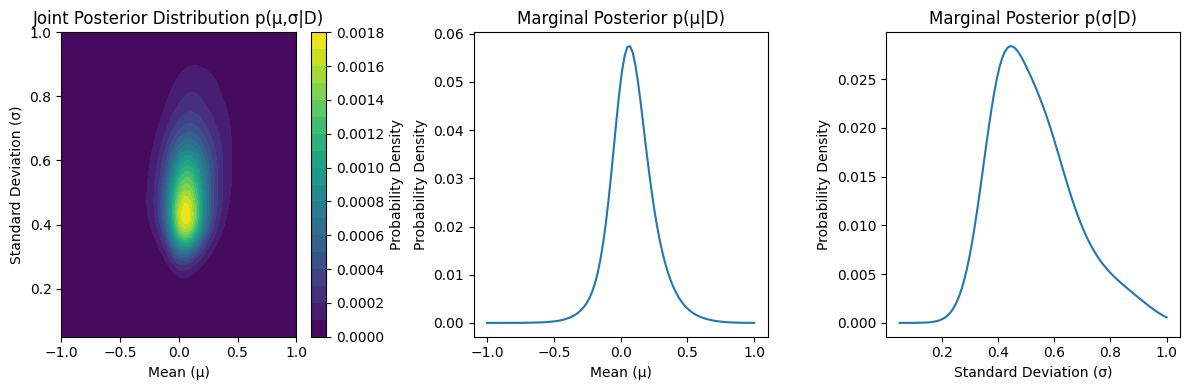

In [480]:
num_bins = 100
mean_range = np.linspace(-1, 1, num_bins)
std_range = np.linspace(0.05, 1, num_bins)
mean_grid, std_grid = np.meshgrid(mean_range, std_range)

log_predicted_posterior_grid = -np.inf * np.ones_like(mean_grid)

# p(sigma, mu|D) = 0.5*[p(mu|sigma, D) * p(sigma|D) + p(sigma|mu, D) * p(mu|D)]
for i in range(std_grid.shape[0]):    # row (sigma)
    for j in range(mean_grid.shape[1]):  # column (mu)
        mu_val = mean_grid[i, j]
        sigma_val = std_grid[i, j]
        
        sigma_idx = i
        mu_idx = j
        
        # First term: 0.5 * p(mu|sigma, D) * p(sigma|D)
        
        # p(sigma|D)
        log_sigma_prob = -np.inf
        for k in range(len(theta_2_posterior_mean)):
            log_sigma_comp = np.log(theta_2_posterior_weight[k]) + norm.logpdf(sigma_val, 
                                                                              loc=theta_2_posterior_mean[k], 
                                                                              scale=theta_2_posterior_std[k])
            log_sigma_prob = np.logaddexp(log_sigma_prob, log_sigma_comp)
        
        # p(mu|sigma, D)
        log_mu_given_sigma_prob = -np.inf
        for l in range(theta_1_cond_mean.shape[1]):  # calculate over multiple gmm
            log_mu_comp = np.log(theta_1_cond_weight[sigma_idx, l]) + norm.logpdf(mu_val, 
                                                                                 loc=theta_1_cond_mean[sigma_idx, l], 
                                                                                 scale=theta_1_cond_std[sigma_idx, l])
            log_mu_given_sigma_prob = np.logaddexp(log_mu_given_sigma_prob, log_mu_comp)
        
        
        log_term1 = np.log(0.5) + log_sigma_prob + log_mu_given_sigma_prob
        
        # Second term: 0.5 * p(sigma|mu, D) * p(mu|D)
        
        # p(mu|D)
        log_mu_prob = -np.inf
        for k in range(len(theta_1_posterior_mean)):
            log_mu_comp = np.log(theta_1_posterior_weight[k]) + norm.logpdf(mu_val, 
                                                                          loc=theta_1_posterior_mean[k], 
                                                                          scale=theta_1_posterior_std[k])
            log_mu_prob = np.logaddexp(log_mu_prob, log_mu_comp)
        
        # p(sigma|mu, D)
        log_sigma_given_mu_prob = -np.inf
        for l in range(theta_2_cond_mean.shape[1]):
            log_sigma_comp = np.log(theta_2_cond_weight[mu_idx, l]) + norm.logpdf(sigma_val, 
                                                                                loc=theta_2_cond_mean[mu_idx, l], 
                                                                                scale=theta_2_cond_std[mu_idx, l])
            log_sigma_given_mu_prob = np.logaddexp(log_sigma_given_mu_prob, log_sigma_comp)
        
        log_term2 = np.log(0.5) + log_mu_prob + log_sigma_given_mu_prob
        
        # log space
        log_predicted_posterior_grid[i, j] = np.logaddexp(log_term1, log_term2)


log_predicted_posterior_grid -= np.max(log_predicted_posterior_grid)
predicted_posterior_grid = np.exp(log_predicted_posterior_grid)
predicted_posterior_grid /= np.sum(predicted_posterior_grid)

# visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
contour = plt.contourf(mean_grid, std_grid, predicted_posterior_grid, cmap='viridis', levels=20)
plt.colorbar(contour, label='Probability Density')
plt.title('Joint Posterior Distribution p(μ,σ|D)')
plt.xlabel('Mean (μ)')
plt.ylabel('Standard Deviation (σ)')
plt.tight_layout()

# marginal distribution
marginal_mu = np.sum(predicted_posterior_grid, axis=0)  
marginal_sigma = np.sum(predicted_posterior_grid, axis=1)

plt.subplot(1, 3, 2)
plt.plot(mean_range, marginal_mu)
plt.title('Marginal Posterior p(μ|D)')
plt.xlabel('Mean (μ)')
plt.ylabel('Probability Density')

plt.subplot(1, 3, 3)
plt.plot(std_range, marginal_sigma)
plt.title('Marginal Posterior p(σ|D)')
plt.xlabel('Standard Deviation (σ)')
plt.ylabel('Probability Density')

plt.tight_layout()
plt.show()

In [465]:
def compute_true_posterior(mean_grid, std_grid, log_likelihood_grid, joint_prior_pdf):
    """
    Compute true posterior using Bayes' rule
    
    Args:
        mean_grid: Grid of mean values
        std_grid: Grid of std values
        log_likelihood_grid: Log likelihood for each grid point
        joint_prior_pdf: Joint prior probability density function
        
    Returns:
        posterior_grid: Normalized posterior distribution
    """
    log_prior_grid = np.log(joint_prior_pdf)
    log_posterior_grid = log_likelihood_grid + log_prior_grid
    log_posterior_grid -= np.max(log_posterior_grid)
    posterior_grid = np.exp(log_posterior_grid)
    posterior_grid /= np.sum(posterior_grid)
    return posterior_grid

def compute_predicted_posterior(mean_grid, std_grid, mean_range, std_range, 
                              theta_1_posterior_weight, theta_1_posterior_mean, theta_1_posterior_std,
                              theta_2_posterior_weight, theta_2_posterior_mean, theta_2_posterior_std,
                              theta_1_cond_weight, theta_1_cond_mean, theta_1_cond_std,
                              theta_2_cond_weight, theta_2_cond_mean, theta_2_cond_std):
    """
    Compute predicted posterior using the corrected formula:
    p(sigma, mu|D) = 0.5*[p(mu|sigma, D) * p(sigma|D) + p(sigma|mu, D) * p(mu|D)]
    
    Args:
        mean_grid, std_grid: Meshgrid of parameter values
        mean_range, std_range: 1D arrays of parameter values
        theta_*: Parameters for different distributions
    
    Returns:
        predicted_posterior_grid: Normalized predicted posterior distribution
    """
    log_predicted_posterior_grid = -np.inf * np.ones_like(mean_grid)

    # Calculate predicted joint posterior
    for i in range(std_grid.shape[0]):    # Rows (sigma axis)
        for j in range(mean_grid.shape[1]):  # Columns (mu axis)
            mu_val = mean_grid[i, j]
            sigma_val = std_grid[i, j]
            
            sigma_idx = i
            mu_idx = j
            
            # First term: 0.5 * p(mu|sigma, D) * p(sigma|D)
            
            # Calculate p(sigma|D)
            log_sigma_prob = -np.inf
            for k in range(len(theta_2_posterior_mean)):
                log_sigma_comp = np.log(theta_2_posterior_weight[k]) + norm.logpdf(sigma_val, 
                                                                                  loc=theta_2_posterior_mean[k], 
                                                                                  scale=theta_2_posterior_std[k])
                log_sigma_prob = np.logaddexp(log_sigma_prob, log_sigma_comp)
            
            # Calculate p(mu|sigma, D)
            log_mu_given_sigma_prob = -np.inf
            for l in range(theta_1_cond_mean.shape[1]):  # Iterate through GMM components
                log_mu_comp = np.log(theta_1_cond_weight[sigma_idx, l]) + norm.logpdf(mu_val, 
                                                                                    loc=theta_1_cond_mean[sigma_idx, l], 
                                                                                    scale=theta_1_cond_std[sigma_idx, l])
                log_mu_given_sigma_prob = np.logaddexp(log_mu_given_sigma_prob, log_mu_comp)
            
            # First term contribution
            log_term1 = np.log(0.5) + log_sigma_prob + log_mu_given_sigma_prob
            
            # Second term: 0.5 * p(sigma|mu, D) * p(mu|D)
            
            # Calculate p(mu|D)
            log_mu_prob = -np.inf
            for k in range(len(theta_1_posterior_mean)):
                log_mu_comp = np.log(theta_1_posterior_weight[k]) + norm.logpdf(mu_val, 
                                                                              loc=theta_1_posterior_mean[k], 
                                                                              scale=theta_1_posterior_std[k])
                log_mu_prob = np.logaddexp(log_mu_prob, log_mu_comp)
            
            # Calculate p(sigma|mu, D)
            log_sigma_given_mu_prob = -np.inf
            for l in range(theta_2_cond_mean.shape[1]):  # Iterate through GMM components
                log_sigma_comp = np.log(theta_2_cond_weight[mu_idx, l]) + norm.logpdf(sigma_val, 
                                                                                    loc=theta_2_cond_mean[mu_idx, l], 
                                                                                    scale=theta_2_cond_std[mu_idx, l])
                log_sigma_given_mu_prob = np.logaddexp(log_sigma_given_mu_prob, log_sigma_comp)
            
            # Second term contribution
            log_term2 = np.log(0.5) + log_mu_prob + log_sigma_given_mu_prob
            
            # Combine both terms (in log space)
            log_predicted_posterior_grid[i, j] = np.logaddexp(log_term1, log_term2)

    # Normalize predicted posterior
    log_predicted_posterior_grid -= np.max(log_predicted_posterior_grid)
    predicted_posterior_grid = np.exp(log_predicted_posterior_grid)
    predicted_posterior_grid /= np.sum(predicted_posterior_grid)
    
    return predicted_posterior_grid

def compute_marginals_and_stats(posterior_grid, mean_range, std_range):
    """
    Compute marginal distributions and their statistics
    
    Args:
        posterior_grid: Posterior distribution grid
        mean_range: Range of mean values
        std_range: Range of std values
        
    Returns:
        Dictionary containing marginal distributions and their statistics
    """
    # Marginalize std to get posterior over mean
    marginalized_mean = np.sum(posterior_grid, axis=0)
    
    # Calculate posterior mean for mean parameter
    posterior_mean = np.sum(marginalized_mean * mean_range) / np.sum(marginalized_mean)
    posterior_mean_std = np.sqrt(np.sum(marginalized_mean * (mean_range - posterior_mean)**2) / np.sum(marginalized_mean))
    
    # Marginalize mean to get posterior over std
    marginalized_std = np.sum(posterior_grid, axis=1)
    
    # Calculate posterior mean for std parameter
    posterior_std = np.sum(marginalized_std * std_range) / np.sum(marginalized_std)
    posterior_std_std = np.sqrt(np.sum(marginalized_std * (std_range - posterior_std)**2) / np.sum(marginalized_std))
    
    return {
        'marginalized_mean': marginalized_mean,
        'marginalized_std': marginalized_std,
        'posterior_mean': posterior_mean,
        'posterior_mean_std': posterior_mean_std,
        'posterior_std': posterior_std,
        'posterior_std_std': posterior_std_std
    }

def create_visualization(mean_grid, std_grid, joint_prior_pdf, log_likelihood_grid, 
                        posterior_grid, predicted_posterior_grid, 
                        marginalized_mean_true, marginalized_mean_predicted, 
                        mean_range, title_info):
    """
    Create visualization plots
    
    Args:
        Various grids and distributions for plotting
        title_info: Information to include in plot title
    """
    plt.figure(figsize=(24, 5))
    
    # Plot joint prior
    plt.subplot(1, 5, 1)
    plt.contourf(mean_grid, std_grid, joint_prior_pdf, cmap='viridis')
    plt.title(f'Joint Prior Distribution\n{title_info}')
    plt.xlabel('Mean')
    plt.ylabel('Standard Deviation')
    plt.colorbar()

    # Plot likelihood
    plt.subplot(1, 5, 2)
    plt.contourf(mean_grid, std_grid, np.exp(log_likelihood_grid - np.max(log_likelihood_grid)), cmap='viridis')
    plt.title('Likelihood Distribution')
    plt.xlabel('Mean')
    plt.ylabel('Standard Deviation')
    plt.colorbar()

    # Plot true posterior
    plt.subplot(1, 5, 3)
    plt.contourf(mean_grid, std_grid, posterior_grid, cmap='viridis')
    plt.title('True Posterior Distribution')
    plt.xlabel('Mean')
    plt.ylabel('Standard Deviation')
    plt.colorbar()

    # Plot predicted posterior
    plt.subplot(1, 5, 4)
    plt.contourf(mean_grid, std_grid, predicted_posterior_grid, cmap='viridis')
    plt.title('Predicted Joint Posterior Distribution')
    plt.xlabel('Mean')
    plt.ylabel('Standard Deviation')
    plt.colorbar()

    # Plot marginal posterior for mean
    plt.subplot(1, 5, 5)
    plt.plot(mean_range, marginalized_mean_true, label='True Posterior')
    plt.plot(mean_range, marginalized_mean_predicted, label='Predicted Posterior')
    plt.legend()
    plt.title('Marginalized Posterior over Mean')
    plt.xlabel('Mean')
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

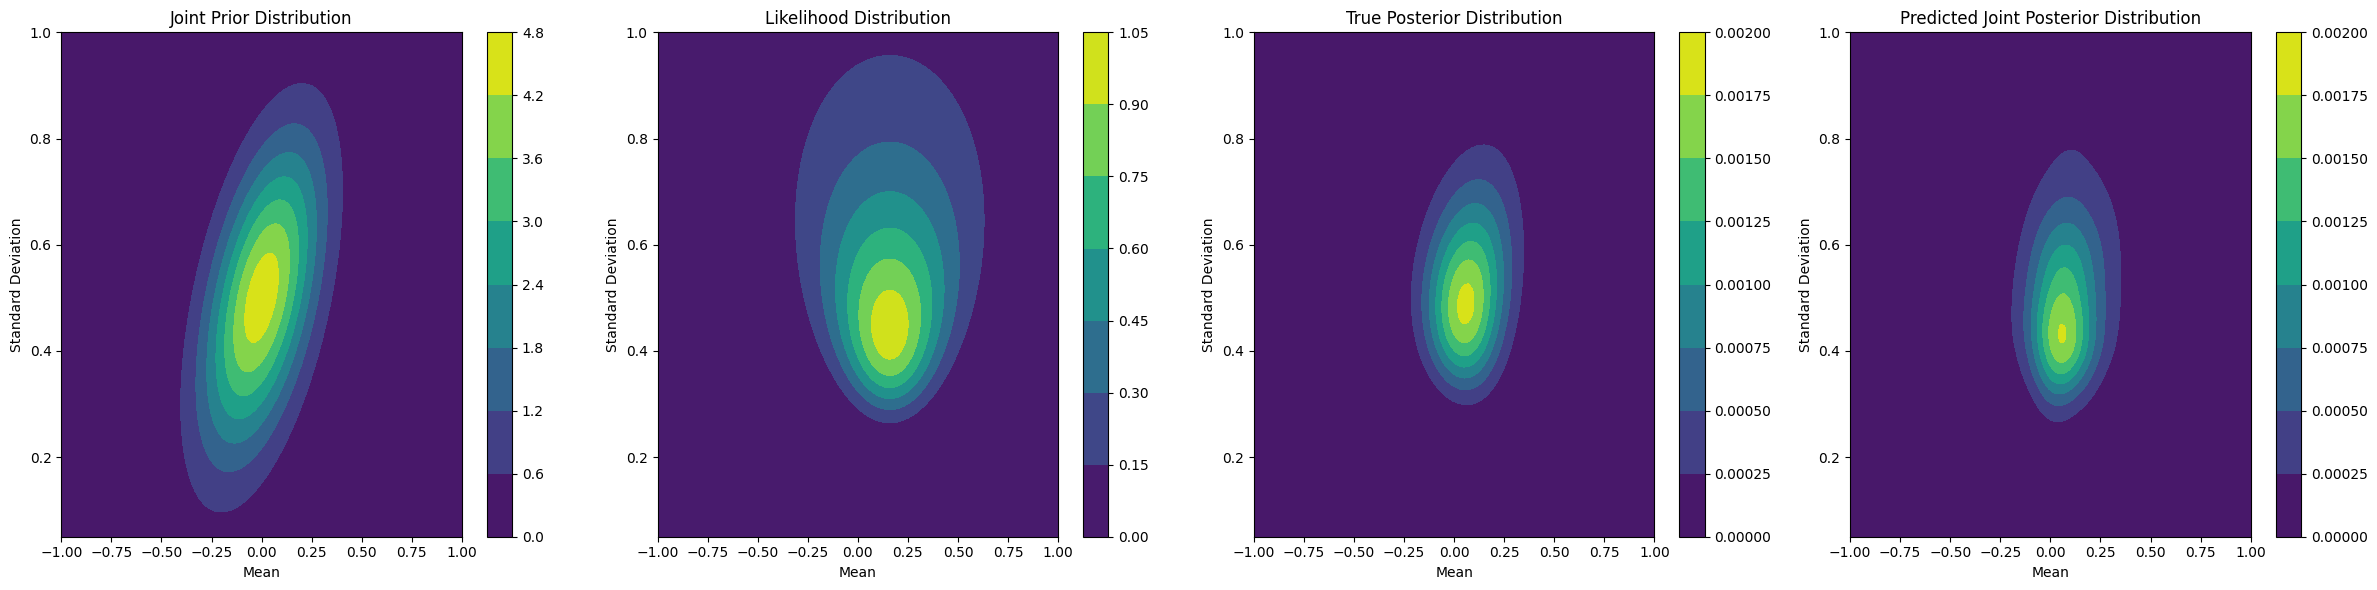

In [481]:
num_bins = 100
mean_range = np.linspace(-1, 1, num_bins)
std_range = np.linspace(0.05, 1, num_bins)
mean_grid, std_grid = np.meshgrid(mean_range, std_range)

cov_matrix = [[joint_std_theta_1**2, joint_rho * joint_std_theta_1 * joint_std_theta_2],
              [joint_rho * joint_std_theta_1 * joint_std_theta_2, joint_std_theta_2**2]]
mean_vector = [joint_mean_theta_1, joint_mean_theta_2]
joint_prior = multivariate_normal(mean=mean_vector, cov=cov_matrix)

# joint prior
joint_prior_pdf = joint_prior.pdf(np.dstack((mean_grid, std_grid)))


# Calculate likelihood
data = batch_theta_1_marginal.yc_data.reshape(-1).numpy()
log_likelihood_grid = np.zeros_like(mean_grid)
for i in range(mean_grid.shape[0]):
    for j in range(mean_grid.shape[1]):
        mean = mean_grid[i, j]
        std = std_grid[i, j]
        log_likelihood_grid[i, j] = np.sum(norm.logpdf(data, loc=mean, scale=std))

# Compute true posterior
posterior_grid = compute_true_posterior(mean_grid, std_grid, log_likelihood_grid, joint_prior_pdf)

# Compute predicted posterior
predicted_posterior_grid = compute_predicted_posterior(
    mean_grid, std_grid, mean_range, std_range,
    theta_1_posterior_weight, theta_1_posterior_mean, theta_1_posterior_std,
    theta_2_posterior_weight, theta_2_posterior_mean, theta_2_posterior_std,
    theta_1_cond_weight, theta_1_cond_mean, theta_1_cond_std,
    theta_2_cond_weight, theta_2_cond_mean, theta_2_cond_std
)

# Calculate statistics
true_stats = compute_marginals_and_stats(posterior_grid, mean_range, std_range)
pred_stats = compute_marginals_and_stats(predicted_posterior_grid, mean_range, std_range)

# Store results for comparison
posterior_mean_trues.append(true_stats['posterior_mean'])
posterior_mean_predicteds.append(pred_stats['posterior_mean'])

plt.figure(figsize=(24, 6))

plt.subplot(1, 4, 1)
plt.contourf(mean_grid, std_grid, joint_prior_pdf, cmap='viridis')
plt.title('Joint Prior Distribution')
plt.xlabel('Mean')
plt.ylabel('Standard Deviation')
plt.colorbar()

plt.subplot(1, 4, 2)
plt.contourf(mean_grid, std_grid, np.exp(log_likelihood_grid - np.max(log_likelihood_grid)), cmap='viridis')
plt.title('Likelihood Distribution')
plt.xlabel('Mean')
plt.ylabel('Standard Deviation')
plt.colorbar()

plt.subplot(1, 4, 3)
plt.contourf(mean_grid, std_grid, posterior_grid, cmap='viridis')
plt.title('True Posterior Distribution')
plt.xlabel('Mean')
plt.ylabel('Standard Deviation')
plt.colorbar()

plt.subplot(1, 4, 4)
plt.contourf(mean_grid, std_grid, predicted_posterior_grid, cmap='viridis')
plt.title('Predicted Joint Posterior Distribution')
plt.xlabel('Mean')
plt.ylabel('Standard Deviation')
plt.colorbar()

plt.tight_layout()
plt.show()


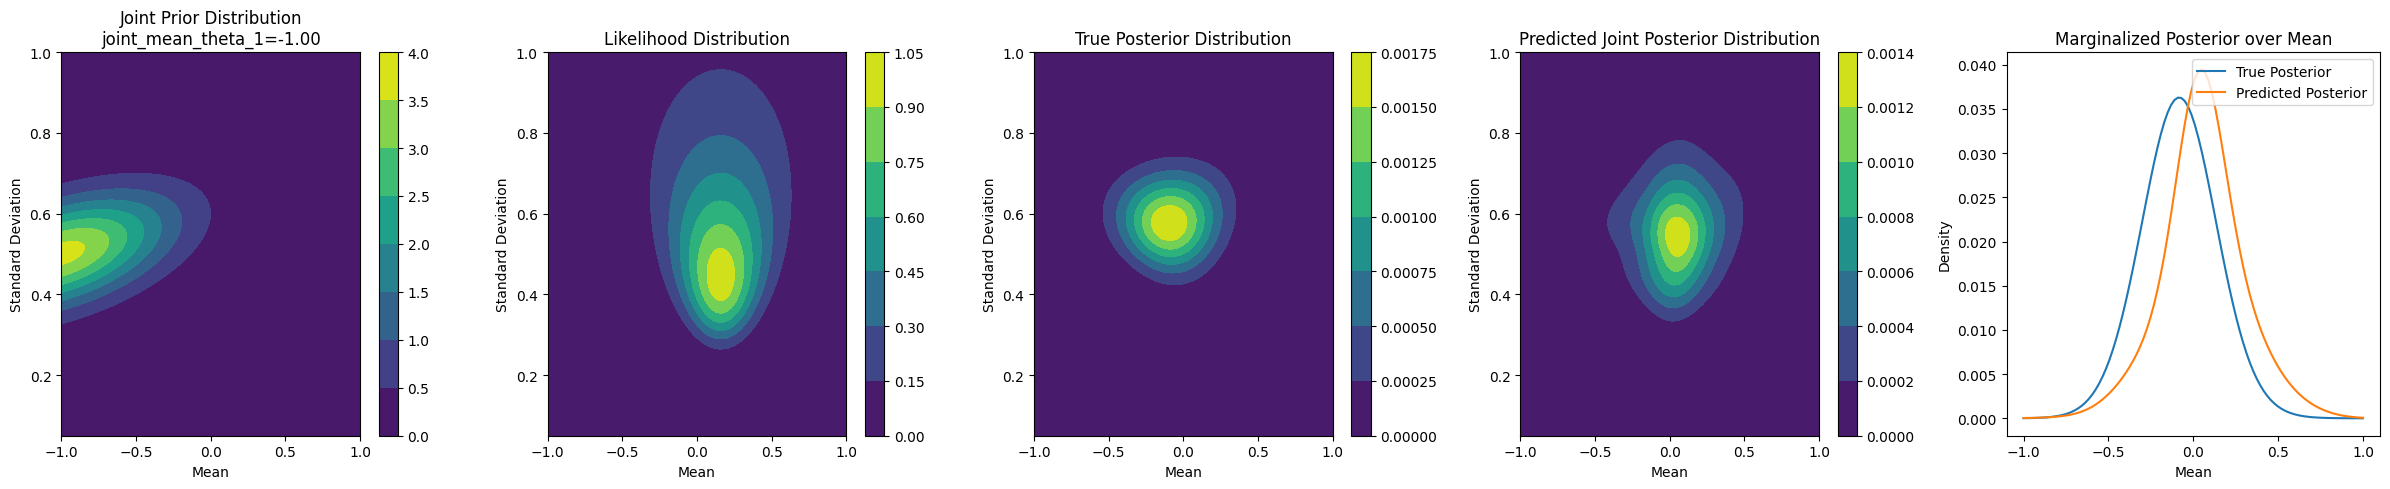

Mean prior=-1.00: True posterior mean=-0.0830
Mean prior=-1.00: Predicted posterior mean=0.0582


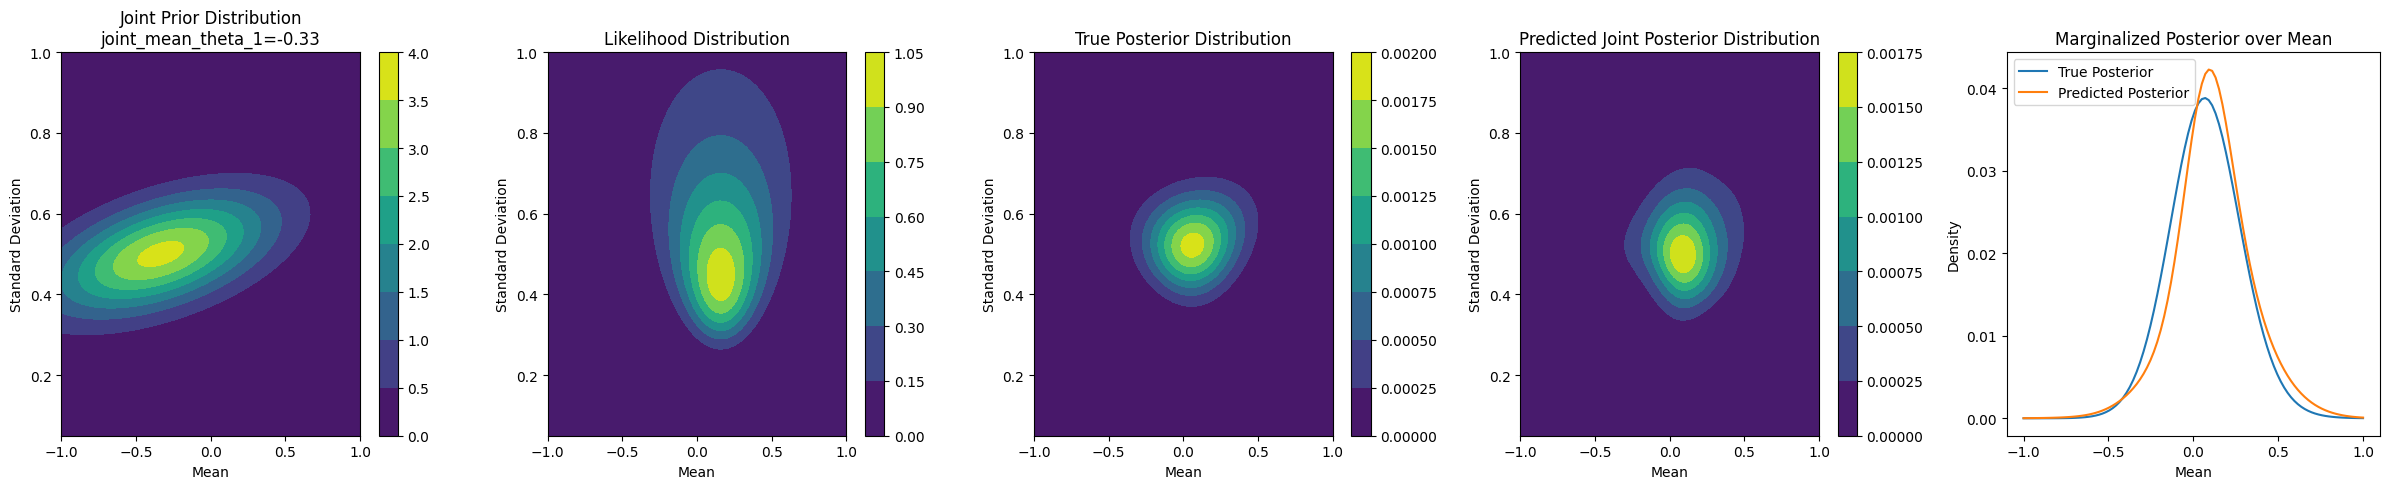

Mean prior=-0.33: True posterior mean=0.0754
Mean prior=-0.33: Predicted posterior mean=0.1159


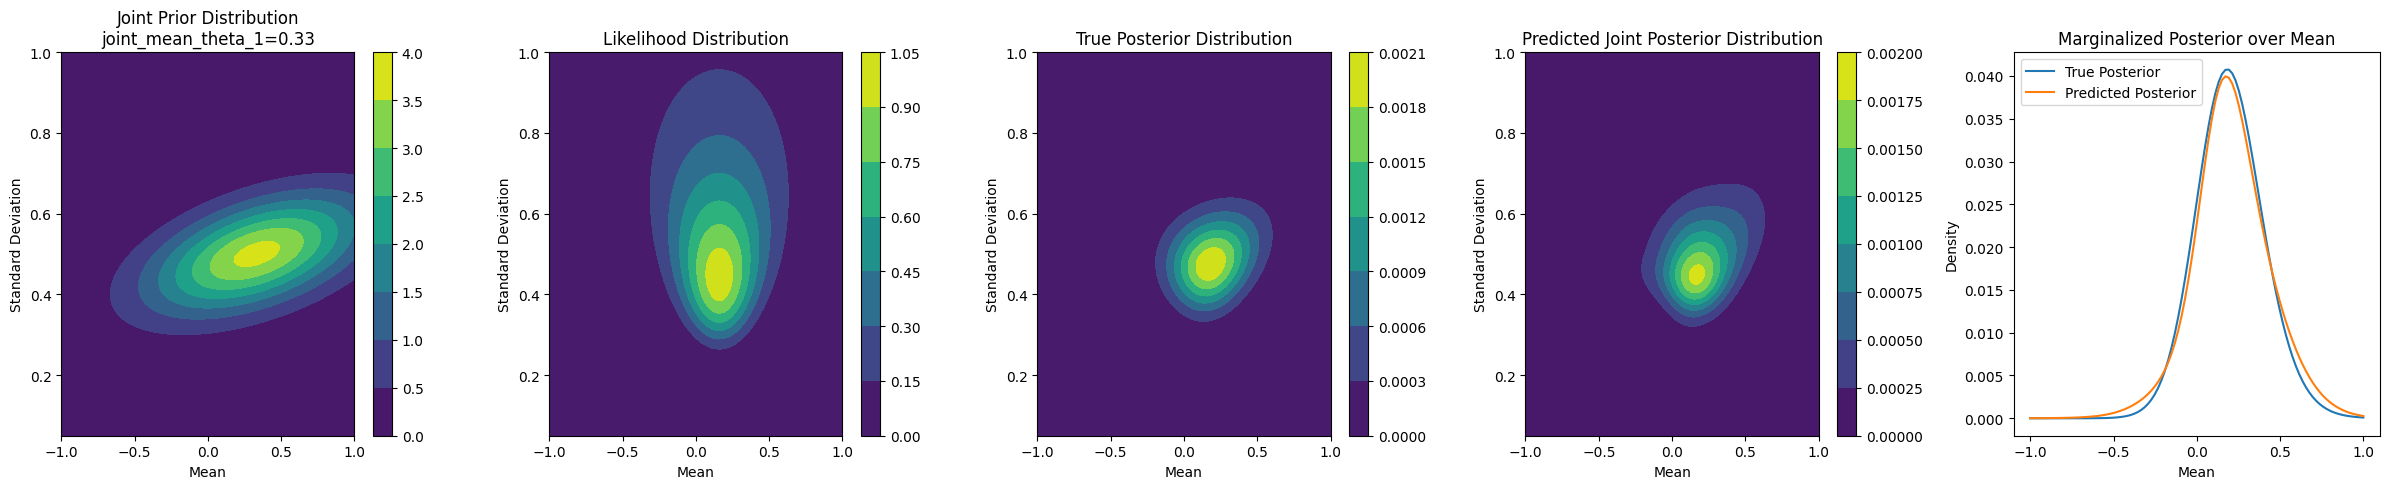

Mean prior=0.33: True posterior mean=0.2015
Mean prior=0.33: Predicted posterior mean=0.2097


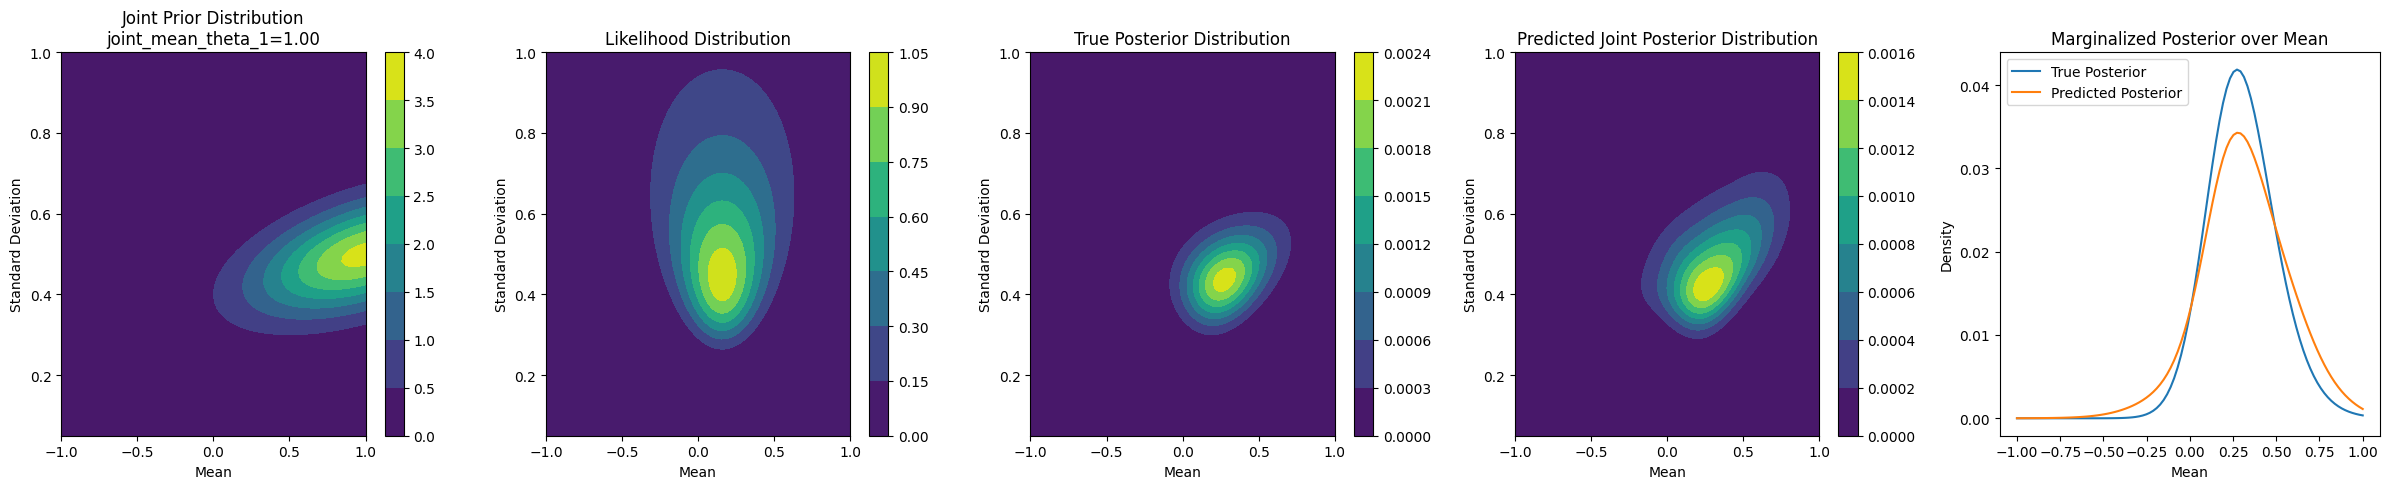

Mean prior=1.00: True posterior mean=0.3027
Mean prior=1.00: Predicted posterior mean=0.3142


In [466]:
joint_mean_theta_2 = torch.tensor(0.5)
joint_std_theta_1 = torch.tensor(0.5)
joint_std_theta_2 = torch.tensor(0.1)
joint_rho = torch.tensor(0.5)

# Values for joint_mean_theta_1 to iterate over
joint_mean_theta_1_values = np.linspace(-1, 1, 4)

# Placeholder for results
posterior_mean_trues = []
posterior_mean_predicteds = []

# Set up grid for parameter space
num_bins = 100
mean_range = np.linspace(-1, 1, num_bins)
std_range = np.linspace(0.05, 1, num_bins)
mean_grid, std_grid = np.meshgrid(mean_range, std_range)

for joint_mean_theta_1_value in joint_mean_theta_1_values:
    joint_mean_theta_1 = torch.tensor(joint_mean_theta_1_value)

    # Generate samples using autoregressive model
    batch_theta_1_marginal, batch_theta_1_cond, batch_theta_2_marginal, batch_theta_2_cond = sample_ar(
        dataset, 
        5, 
        joint_mean_theta_1, joint_mean_theta_2, 
        joint_std_theta_1, joint_std_theta_2, 
        joint_rho
    )

    # Get model predictions
    out_theta_1_marginal = model_pi_twoway.forward(batch_theta_1_marginal, predict=True)
    out_theta_2_marginal = model_pi_twoway.forward(batch_theta_2_marginal, predict=True)
    out_theta_1_cond = model_pi_twoway.forward(batch_theta_1_cond, predict=True)
    out_theta_2_cond = model_pi_twoway.forward(batch_theta_2_cond, predict=True)

    # Extract distribution parameters
    # p(mean | D)
    theta_1_posterior_weight = out_theta_1_marginal.mixture_weights[0, 0].detach().numpy()
    theta_1_posterior_std = out_theta_1_marginal.mixture_stds[0, 0].detach().numpy()
    theta_1_posterior_mean = out_theta_1_marginal.mixture_means[0, 0].detach().numpy()
    
    # p(std | D)
    theta_2_posterior_weight = out_theta_2_marginal.mixture_weights[0, 1].detach().numpy()
    theta_2_posterior_std = out_theta_2_marginal.mixture_stds[0, 1].detach().numpy()
    theta_2_posterior_mean = out_theta_2_marginal.mixture_means[0, 1].detach().numpy()
    
    # p(mean | std, D)
    theta_1_cond_weight = out_theta_2_cond.mixture_weights[:, 0, :].detach().numpy()
    theta_1_cond_std = out_theta_2_cond.mixture_stds[:, 0, :].detach().numpy()
    theta_1_cond_mean = out_theta_2_cond.mixture_means[:, 0, :].detach().numpy()
    
    # p(std | mean, D)
    theta_2_cond_weight = out_theta_1_cond.mixture_weights[:, 0, :].detach().numpy()
    theta_2_cond_std = out_theta_1_cond.mixture_stds[:, 0, :].detach().numpy()
    theta_2_cond_mean = out_theta_1_cond.mixture_means[:, 0, :].detach().numpy()

    # Create joint prior distribution
    cov_matrix = [
        [joint_std_theta_1**2, joint_rho * joint_std_theta_1 * joint_std_theta_2],
        [joint_rho * joint_std_theta_1 * joint_std_theta_2, joint_std_theta_2**2]
    ]
    mean_vector = [joint_mean_theta_1, joint_mean_theta_2]
    joint_prior = multivariate_normal(mean=mean_vector, cov=cov_matrix)
    joint_prior_pdf = joint_prior.pdf(np.dstack((mean_grid, std_grid)))

    # Calculate likelihood
    data = batch_theta_1_marginal.yc_data.reshape(-1).numpy()
    log_likelihood_grid = np.zeros_like(mean_grid)
    for i in range(mean_grid.shape[0]):
        for j in range(mean_grid.shape[1]):
            mean = mean_grid[i, j]
            std = std_grid[i, j]
            log_likelihood_grid[i, j] = np.sum(norm.logpdf(data, loc=mean, scale=std))

    # Compute true posterior
    posterior_grid = compute_true_posterior(mean_grid, std_grid, log_likelihood_grid, joint_prior_pdf)
    
    # Compute predicted posterior
    predicted_posterior_grid = compute_predicted_posterior(
        mean_grid, std_grid, mean_range, std_range,
        theta_1_posterior_weight, theta_1_posterior_mean, theta_1_posterior_std,
        theta_2_posterior_weight, theta_2_posterior_mean, theta_2_posterior_std,
        theta_1_cond_weight, theta_1_cond_mean, theta_1_cond_std,
        theta_2_cond_weight, theta_2_cond_mean, theta_2_cond_std
    )
    
    # Calculate statistics
    true_stats = compute_marginals_and_stats(posterior_grid, mean_range, std_range)
    pred_stats = compute_marginals_and_stats(predicted_posterior_grid, mean_range, std_range)
    
    # Store results for comparison
    posterior_mean_trues.append(true_stats['posterior_mean'])
    posterior_mean_predicteds.append(pred_stats['posterior_mean'])
    
    # Create visualization
    title_info = f'joint_mean_theta_1={joint_mean_theta_1_value:.2f}'
    create_visualization(
        mean_grid, std_grid, joint_prior_pdf, log_likelihood_grid,
        posterior_grid, predicted_posterior_grid,
        true_stats['marginalized_mean'], pred_stats['marginalized_mean'],
        mean_range, title_info
    )
    
    # Print posterior statistics
    print(f"Mean prior={joint_mean_theta_1_value:.2f}: True posterior mean={true_stats['posterior_mean']:.4f}")
    print(f"Mean prior={joint_mean_theta_1_value:.2f}: Predicted posterior mean={pred_stats['posterior_mean']:.4f}")

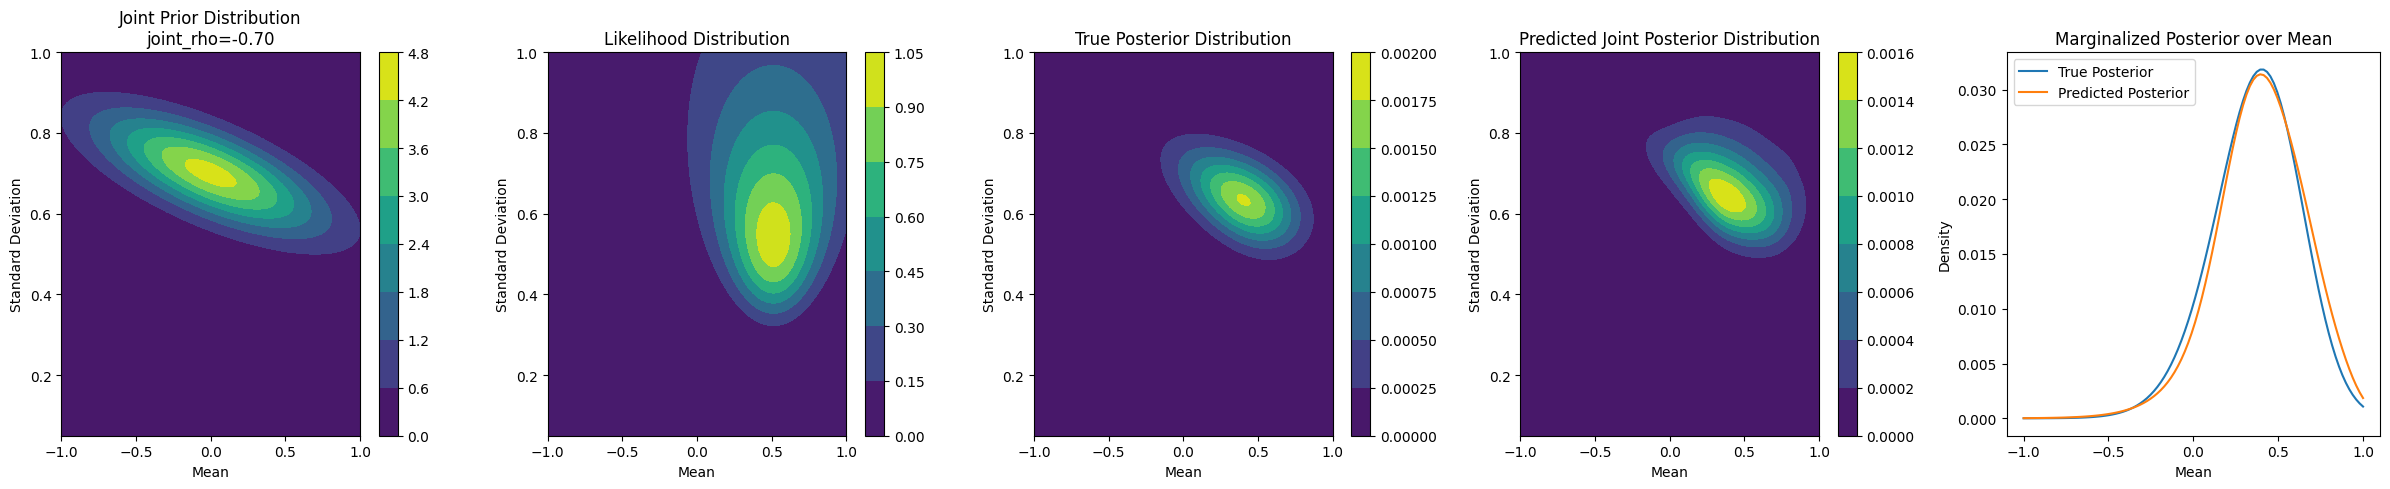

joint_rho=-0.70: Posterior mean (true) for std: 0.6457
joint_rho=-0.70: Posterior mean (predicted) for std: 0.6763


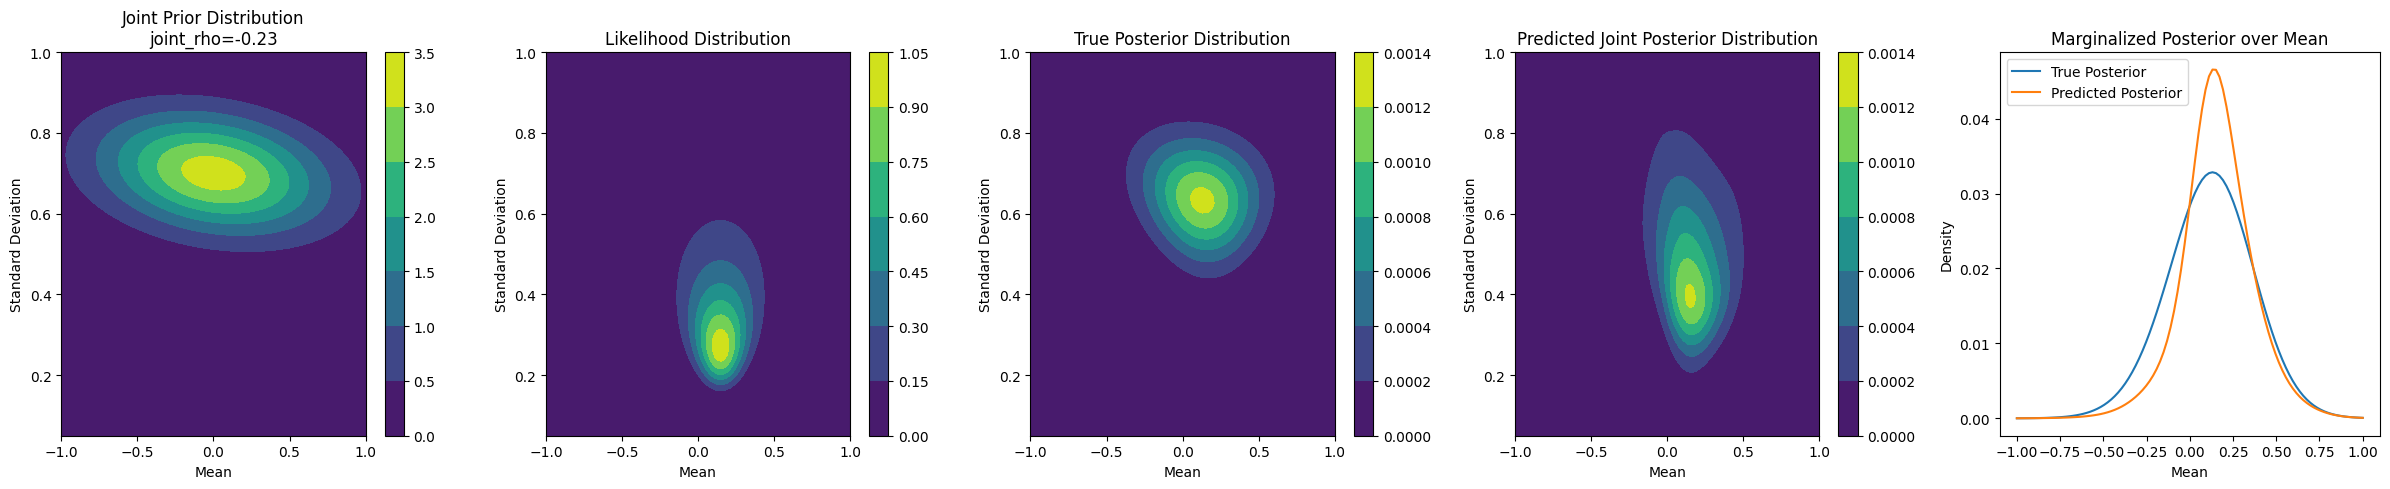

joint_rho=-0.23: Posterior mean (true) for std: 0.6457
joint_rho=-0.23: Posterior mean (predicted) for std: 0.5207


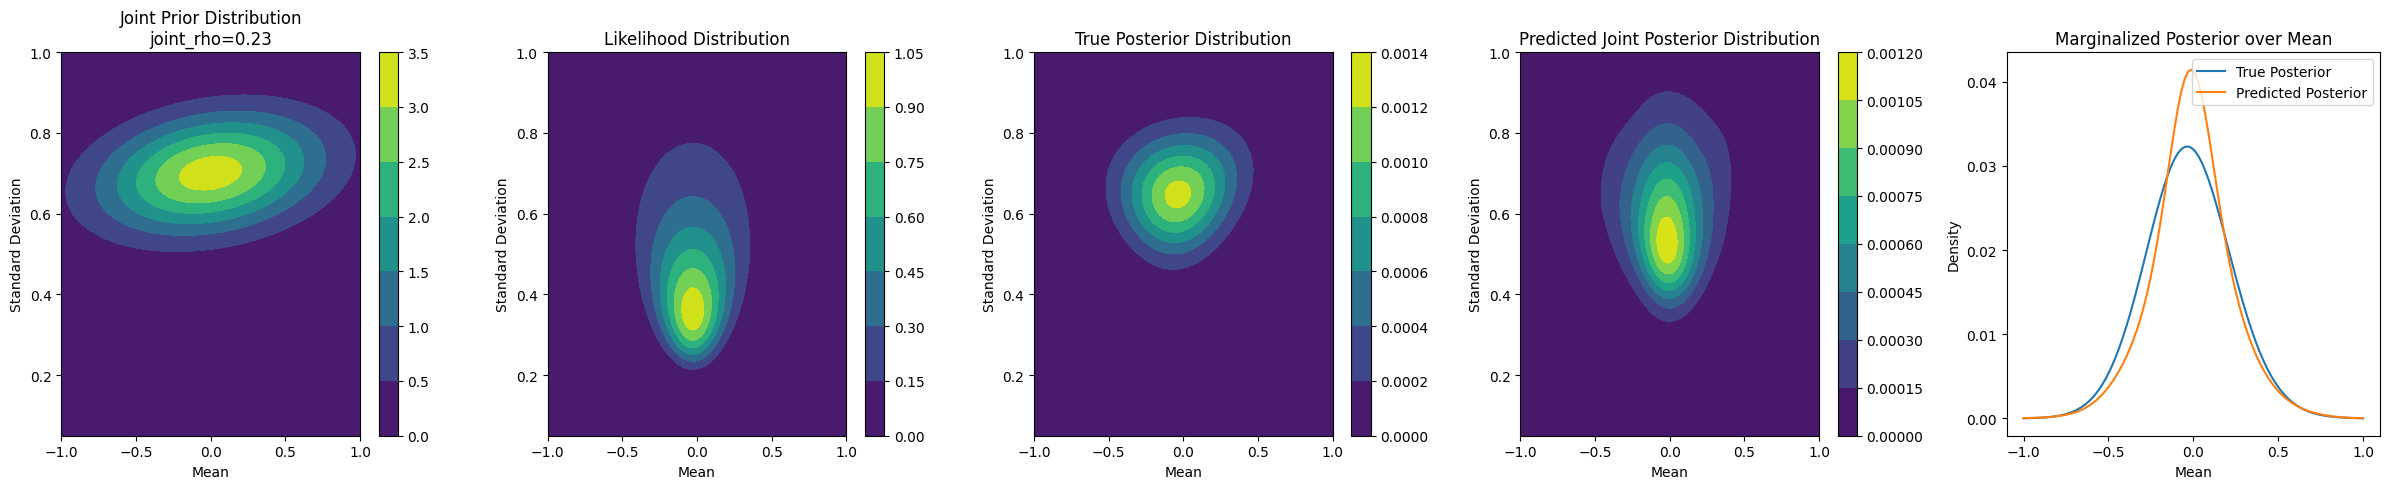

joint_rho=0.23: Posterior mean (true) for std: 0.6606
joint_rho=0.23: Posterior mean (predicted) for std: 0.6183


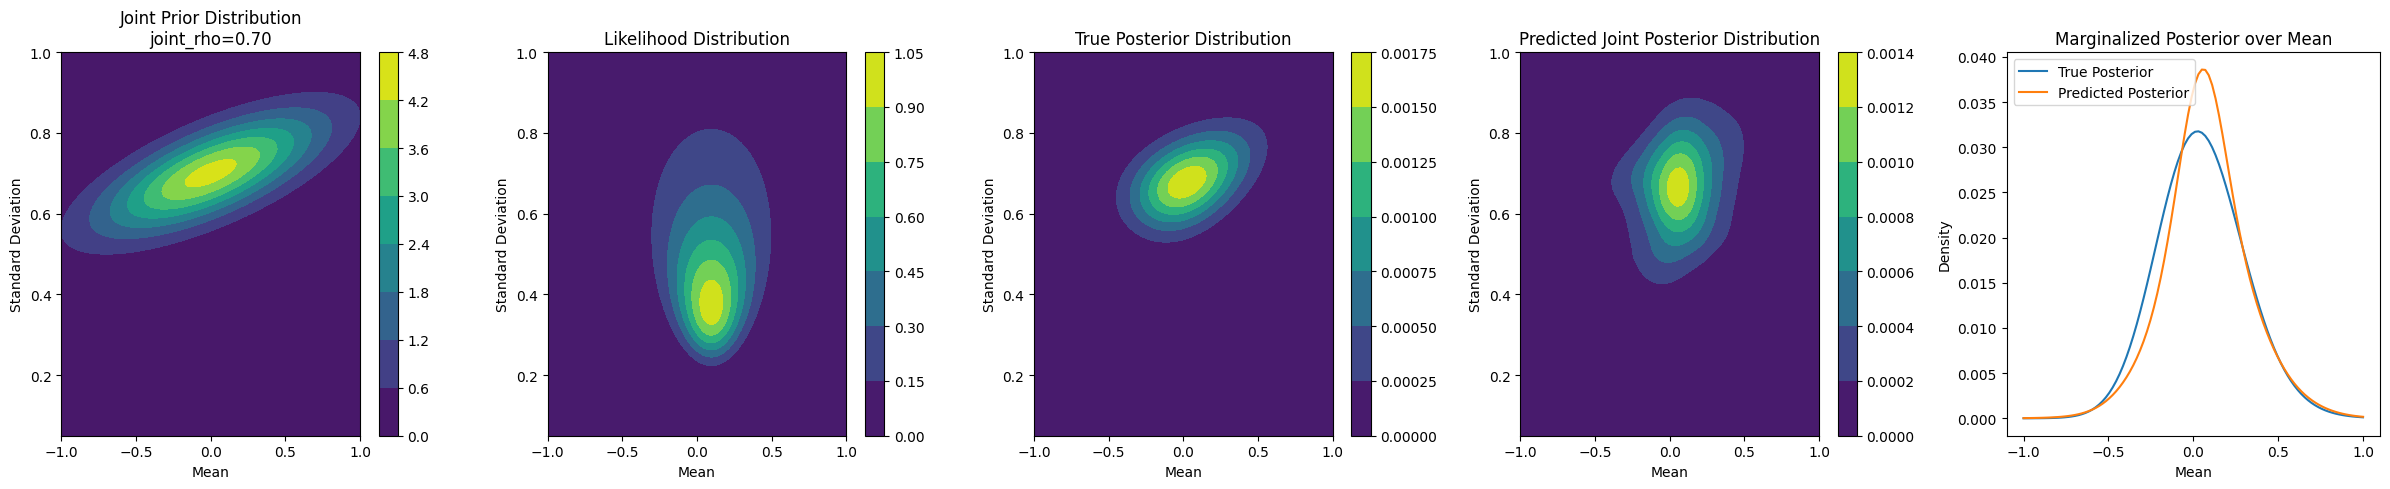

joint_rho=0.70: Posterior mean (true) for std: 0.6872
joint_rho=0.70: Posterior mean (predicted) for std: 0.6681


In [458]:
# Define joint prior parameters
joint_mean_theta_1 = torch.tensor(0.0)
joint_mean_theta_2 = torch.tensor(0.7)
joint_std_theta_1 = torch.tensor(0.5)
joint_std_theta_2 = torch.tensor(0.1)

# Values for joint_rho to iterate over
joint_rho_values = np.linspace(-0.7, 0.7, 4)

# Placeholder for results
posterior_mean_trues = []
posterior_mean_predicteds = []

for joint_rho_value in joint_rho_values:
    joint_rho = torch.tensor(joint_rho_value)

    # Generate samples using autoregressive model
    batch_theta_1_marginal, batch_theta_1_cond, batch_theta_2_marginal, batch_theta_2_cond = sample_ar(dataset,
                                                                                                    5, 
                                                                                                    joint_mean_theta_1,
                                                                                                    joint_mean_theta_2,
                                                                                                    joint_std_theta_1,
                                                                                                    joint_std_theta_2,
                                                                                                    joint_rho)

    # Get model predictions for various distributions
    out_theta_1_marginal = model_pi_twoway.forward(batch_theta_1_marginal, predict=True)
    samples_theta_1_marginal = out_theta_1_marginal.samples

    out_theta_2_marginal = model_pi_twoway.forward(batch_theta_2_marginal, predict=True)
    samples_theta_2_marginal = out_theta_2_marginal.samples

    out_theta_1_cond = model_pi_twoway.forward(batch_theta_1_cond, predict=True)
    samples_theta_1_cond = out_theta_1_cond.samples

    out_theta_2_cond = model_pi_twoway.forward(batch_theta_2_cond, predict=True)
    samples_theta_2_cond = out_theta_2_cond.samples

    # Extract marginal distribution parameters
    # p(mean | D) - Mixture of Gaussians parameters
    theta_1_posterior_weight = out_theta_1_marginal.mixture_weights[0, 0].detach().numpy()
    theta_1_posterior_std = out_theta_1_marginal.mixture_stds[0, 0].detach().numpy()
    theta_1_posterior_mean = out_theta_1_marginal.mixture_means[0, 0].detach().numpy()
    
    # p(std | D) - Mixture of Gaussians parameters
    theta_2_posterior_weight = out_theta_2_marginal.mixture_weights[0, 1].detach().numpy()
    theta_2_posterior_std = out_theta_2_marginal.mixture_stds[0, 1].detach().numpy()
    theta_2_posterior_mean = out_theta_2_marginal.mixture_means[0, 1].detach().numpy()
    
    # Extract conditional distribution parameters
    # p(mean | std, D) - Parameters of conditionals for each std value
    theta_1_cond_weight = out_theta_2_cond.mixture_weights[:, 0, :].detach().numpy()
    theta_1_cond_std = out_theta_2_cond.mixture_stds[:, 0, :].detach().numpy()
    theta_1_cond_mean = out_theta_2_cond.mixture_means[:, 0, :].detach().numpy()
    
    # p(std | mean, D) - Parameters of conditionals for each mean value
    theta_2_cond_weight = out_theta_1_cond.mixture_weights[:, 0, :].detach().numpy()
    theta_2_cond_std = out_theta_1_cond.mixture_stds[:, 0, :].detach().numpy()
    theta_2_cond_mean = out_theta_1_cond.mixture_means[:, 0, :].detach().numpy()

    # Set up grid for parameter space
    num_bins = 100
    mean_range = np.linspace(-1, 1, num_bins)
    std_range = np.linspace(0.05, 1, num_bins)
    mean_grid, std_grid = np.meshgrid(mean_range, std_range)

    # Create joint prior distribution using multivariate normal
    cov_matrix = [[joint_std_theta_1**2, joint_rho_value * joint_std_theta_1 * joint_std_theta_2],
                  [joint_rho_value * joint_std_theta_1 * joint_std_theta_2, joint_std_theta_2**2]]
    mean_vector = [joint_mean_theta_1, joint_mean_theta_2]
    joint_prior = multivariate_normal(mean=mean_vector, cov=cov_matrix)

    # Calculate joint prior PDF
    joint_prior_pdf = joint_prior.pdf(np.dstack((mean_grid, std_grid)))

    # Calculate likelihood
    data = batch_theta_1_marginal.yc_data.reshape(-1).numpy()
    log_likelihood_grid = np.zeros_like(mean_grid)
    for i in range(mean_grid.shape[0]):
        for j in range(mean_grid.shape[1]):
            mean = mean_grid[i, j]
            std = std_grid[i, j]
            log_likelihood_grid[i, j] = np.sum(norm.logpdf(data, loc=mean, scale=std))

    # Compute true posterior
    posterior_grid = compute_true_posterior(mean_grid, std_grid, log_likelihood_grid, joint_prior_pdf)
    
    # Compute predicted posterior
    predicted_posterior_grid = compute_predicted_posterior(
        mean_grid, std_grid, mean_range, std_range,
        theta_1_posterior_weight, theta_1_posterior_mean, theta_1_posterior_std,
        theta_2_posterior_weight, theta_2_posterior_mean, theta_2_posterior_std,
        theta_1_cond_weight, theta_1_cond_mean, theta_1_cond_std,
        theta_2_cond_weight, theta_2_cond_mean, theta_2_cond_std
    )
    
    # Calculate statistics for true posterior
    true_stats = compute_marginals_and_stats(posterior_grid, mean_range, std_range)
    
    # Calculate statistics for predicted posterior
    pred_stats = compute_marginals_and_stats(predicted_posterior_grid, mean_range, std_range)
    
    # Store results for comparison
    posterior_mean_trues.append(true_stats['posterior_mean'])
    posterior_mean_predicteds.append(pred_stats['posterior_mean'])
    
    # Create visualization
    title_info = f'joint_rho={joint_rho_value:.2f}'
    create_visualization(
        mean_grid, std_grid, joint_prior_pdf, log_likelihood_grid,
        posterior_grid, predicted_posterior_grid,
        true_stats['marginalized_mean'], pred_stats['marginalized_mean'],
        mean_range, title_info
    )
    
    # Print posterior mean for std
    print(f"joint_rho={joint_rho_value:.2f}: Posterior mean (true) for std: {true_stats['posterior_std']:.4f}")
    print(f"joint_rho={joint_rho_value:.2f}: Posterior mean (predicted) for std: {pred_stats['posterior_std']:.4f}")